In [1]:
#https://github.com/wiseodd/generative-models/blob/master/GAN/wasserstein_gan/wgan_pytorch.py

In [60]:
import pandas as pd
import numpy as np
import wfdb
import ast
#from tqdm import tqdm
import warnings; warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch
import torch.nn.functional as F
from torch import nn
from scipy.stats import wasserstein_distance as ssw
from scipy.stats import kurtosis
from scipy.stats import skew

In [3]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

In [4]:
path = 'ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/'

In [5]:
sampling_rate=100

In [6]:
# load and convert annotation data
Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
dataset_samples = Y.shape[0]
dataset_samples

21837

In [7]:
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

In [8]:
#Y.iloc[0]

In [9]:
#Understanding wfdb
#f= 'records100/00000/00001_lr'
#data1,met= wfdb.rdsamp(path+f)

#print(data1[0])
#print(met)
#pd.DataFrame(data1).plot()

In [10]:
# Load raw signal data
X = load_raw_data(Y, sampling_rate, path)

In [11]:
X.shape

(21837, 1000, 12)

In [12]:
#type(X)

In [13]:
# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

In [14]:
def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

In [15]:
# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

In [16]:
Y.diagnostic_superclass

ecg_id
1        [NORM]
2        [NORM]
3        [NORM]
4        [NORM]
5        [NORM]
          ...  
21833    [STTC]
21834    [NORM]
21835    [STTC]
21836    [NORM]
21837    [NORM]
Name: diagnostic_superclass, Length: 21837, dtype: object

In [17]:
#X[1]

In [18]:
#normal = np.array(['NORM'])
#t= X[np.where(Y.iloc[1].diagnostic_superclass == normal)]
#t

In [19]:
# Split data into train and test
test_fold = 10

# Train
X_train = X[np.where(Y.strat_fold != test_fold)]
y_train = Y[(Y.strat_fold != test_fold)].diagnostic_superclass

#print((X_train))


In [20]:
#X_train[69]
(y_train)

ecg_id
1        [NORM]
2        [NORM]
3        [NORM]
4        [NORM]
5        [NORM]
          ...  
21833    [STTC]
21834    [NORM]
21835    [STTC]
21836    [NORM]
21837    [NORM]
Name: diagnostic_superclass, Length: 19634, dtype: object

In [21]:
cls_MI = ['MI']
mi_count = 0
for j in range(dataset_samples):
    if (j in y_train.index.values) :
        if (y_train[j] == cls_MI):
            print(j-1)
            mi_count = mi_count + 1
            if (mi_count == 10):
                break

7
130
138
141
152
154
160
176
183
188


In [22]:
y_train.index.values

array([    1,     2,     3, ..., 21835, 21836, 21837])

In [23]:
#y_train[8]

In [24]:
#pd.set_option('display.max_rows', None, 'display.max_columns', None)
#pd.reset_option("display.max_rows")

In [25]:
# Test
X_test = X[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass
print(X_test.shape)
y_test

(2203, 1000, 12)


ecg_id
9        [NORM]
38       [NORM]
40       [NORM]
57       [NORM]
59       [NORM]
          ...  
21809    [NORM]
21812      [CD]
21818    [NORM]
21819      [CD]
21826      [MI]
Name: diagnostic_superclass, Length: 2203, dtype: object

In [26]:
torch.manual_seed(111)

In [27]:
train_data_length = 1024

patient_id                                                                11275.0
age                                                                          48.0
sex                                                                             0
height                                                                        NaN
weight                                                                       95.0
nurse                                                                         2.0
site                                                                          0.0
device                                                                  CS-12   E
recording_date                                                1984-12-01 14:49:52
report                          sinusrhythmus linkstyp qrs(t) abnormal    infe...
scp_codes                                  {'IMI': 35.0, 'ABQRS': 0.0, 'SR': 0.0}
heart_axis                                                                    LAD
infarction_stadi

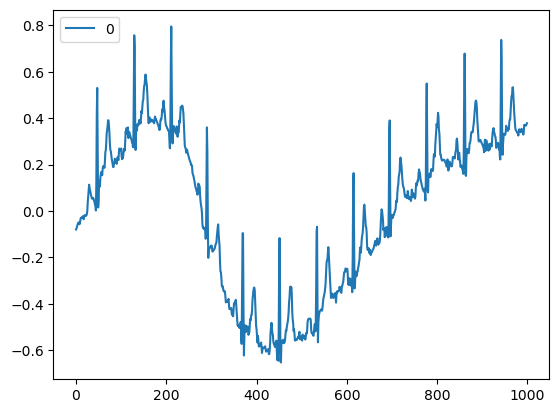

In [28]:
# let's pick an arbitrary signal and it's information from Y index_column
ecg_record = 7  
#Lead_I_data = X[ecg_record][:,0] 
Lead_II_data = X[ecg_record][:,1] # Index of Lead. It is available in meta_data information
#Lead_III_data = X[ecg_record][:,2]
#Lead_IV_data = X[ecg_record][:,3]
#Lead_V_data = X[ecg_record][:,4]
#Lead_VI_data = X[ecg_record][:,5]
#Lead_VII_data = X[ecg_record][:,6]
#Lead_VIII_data = X[ecg_record][:,7]
#Lead_IX_data = X[ecg_record][:,8]
#Lead_X_data = X[ecg_record][:,9]
#Lead_XI_data = X[ecg_record][:,10]
#Lead_XII_data = X[ecg_record][:,11]
#ecg_info = Y.iloc[ecg_record]
ecg_info = Y.iloc[ecg_record]
pd.DataFrame(Lead_II_data).plot()
plt.savefig('lead2mi.png')
#Lead_I_data
print(ecg_info)

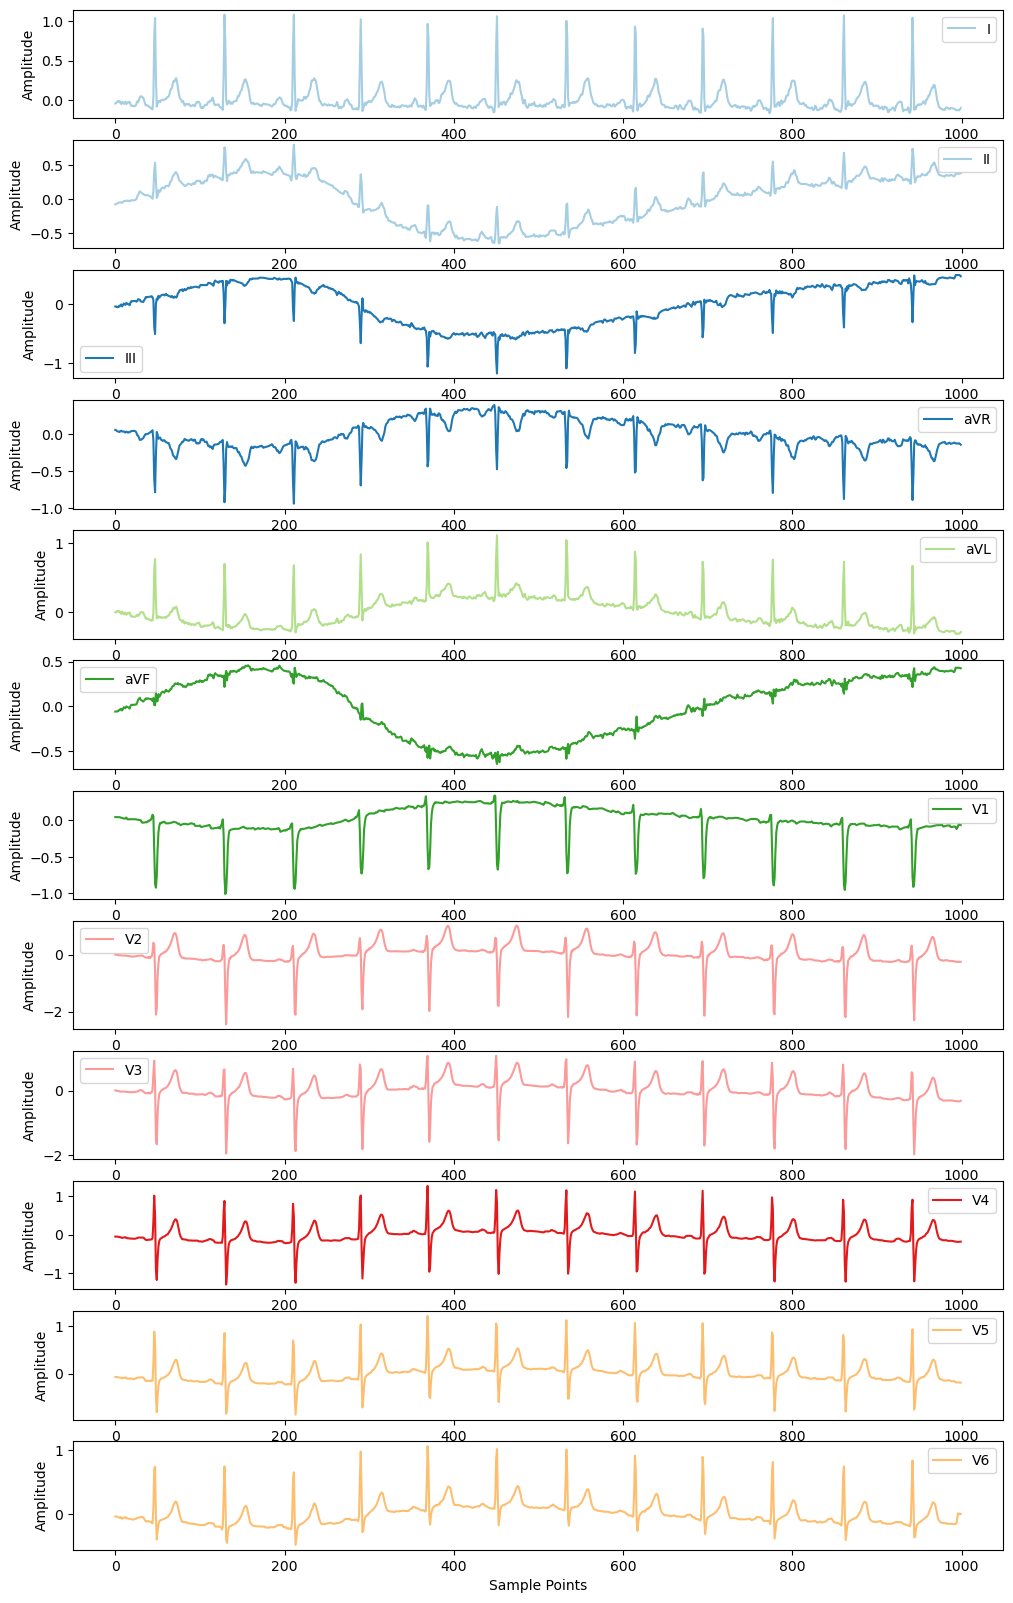

In [29]:
#plot as sub plots for all the 12 leads
leads = ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]
fig, axes = plt.subplots(12,1, figsize =(12,20))

for i, ax in enumerate(axes.flatten()):
    r= X[ecg_record][:,i]
    ax.plot(r,color=plt.cm.Paired(i/20.),label = leads[i])
    axes[i].set_ylabel('Amplitude')
    axes[i].set_xlabel('Sample Points')
    axes[i].set_label(leads[i])
    axes[i].legend()
plt.xlabel("Sample Points")
plt.savefig('ECG12leads_mi.png')
plt.show()

In [30]:
#Logic to fetch 1024 Normal ECG records Lead_II data from the dataset

cls_normal = ['NORM']
temp = 0
#X_trainsample = X[np.where(Y.iloc[0].diagnostic_superclass == cls_normal)]
#n=np.where(Y.iloc[0].diagnostic_superclass == cls_normal)
#print(X[3])

count = 0
#X_train_normal = np.empty((1024,1000,12))
Lead_II_train_data = np.empty((1024,1000,))
#step = np.zeros(s)
for k in range(dataset_samples):
    if (k in y_train.index.values) :
        if (y_train[k] == cls_MI):
            if(count == 1024):
                break
            #X_train_normal[count]=step
            Lead_II_train_data[count] = X[k][:,1]
            count = count+1
print(Lead_II_train_data.shape)

#pd.DataFrame(Lead_I_train_data[0]).plot()

(1024, 1000)


In [31]:
#Lead_I_train_data

In [32]:
train_data = Lead_II_train_data
train_labels = torch.zeros(train_data_length)
train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)
]
#print(train_data.shape)
#max_value = np.max(train_data[0])
#min_value = np.min(train_data[0])
#print(min_value,max_value)
 
#plt.plot(train_data[0])
#pd.DataFrame(train_data[0]).plot()
#plt.show()

In [33]:
eps = 0.0001

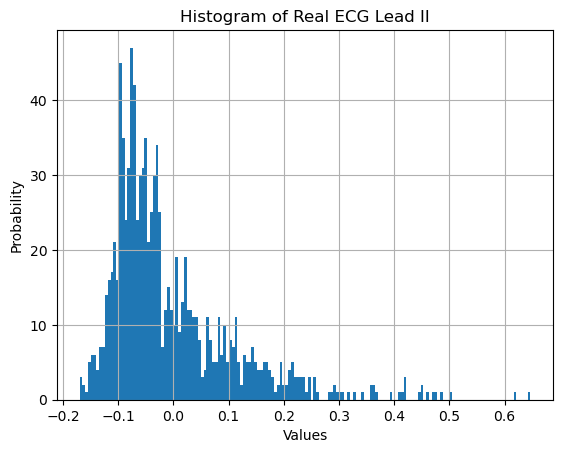

Real ECG Lead [ 3.  2.  1.  5.  6.  6.  4.  7.  7. 14. 16. 17. 21. 16. 45. 35. 24. 31.
 47. 42. 24. 30. 31. 35. 21. 25. 30. 34. 25.  7. 12. 15. 12. 10. 19.  9.
 13. 19. 12. 12. 11. 11.  8.  3.  4. 11.  8.  5.  5. 11.  6. 10.  5.  8.
  7. 11.  5.  2.  6.  5.  5.  7.  5.  4.  4.  5.  5.  4.  3.  1.  2.  5.
  2.  2.  4.  5.  3.  3.  3.  3.  1.  3.  0.  3.  1.  0.  0.  0.  1.  1.
  2.  1.  1.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.  2.  2.  1.  0.  0.
  0.  0.  1.  0.  0.  1.  1.  3.  0.  0.  0.  0.  1.  2.  0.  1.  0.  1.
  1.  0.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.]


In [34]:
# the histogram of the data
n, bins, patches = plt.hist(train_data[0],160)
plt.xlabel('Values')
plt.ylabel('Probability')
plt.title('Histogram of Real ECG Lead II')
plt.grid(True)
plt.show()
print('Real ECG Lead',n)
#prob_real = (n+1)/1000
#print(prob_real)

In [35]:
#pd.DataFrame(train_data[0]).plot(kind='kde');

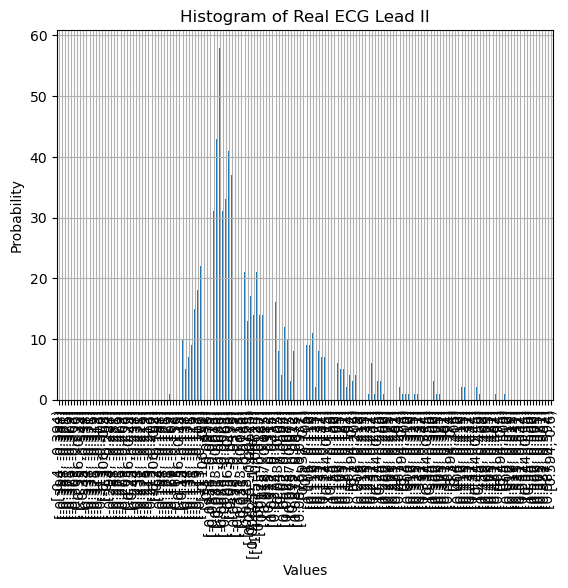

               values  counts
0      [-0.4, -0.394)       0
1    [-0.394, -0.388)       0
2    [-0.388, -0.381)       0
3    [-0.381, -0.375)       0
4    [-0.375, -0.369)       0
..                ...     ...
155    [0.569, 0.575)       0
156    [0.575, 0.581)       0
157    [0.581, 0.587)       0
158    [0.587, 0.594)       0
159      [0.594, 0.6)       0

[160 rows x 2 columns]


In [36]:
step = 0.00625
bin_range = np.arange(-0.4, 0.6+step, step)
#print(bin_range)

outr, bins  = pd.cut(train_data[0], bins=bin_range, include_lowest=True, right=False, retbins=True)
outr.value_counts().plot.bar()
plt.xlabel('Values')
plt.ylabel('Probability')
plt.title('Histogram of Real ECG Lead II')
plt.grid(True)
plt.show()
#print(outr.value_counts())
df1 = outr.value_counts().rename_axis('values').reset_index(name='counts')
real = df1.counts.values
print(df1)
#print(real)
#print(type(real))
preal = real/1000
#print(preal)
#print(type(preal))
nonzero_preal = np.count_nonzero(preal)
#print(nonzero_preal)
preal_eps = eps/nonzero_preal
#print(preal_eps)
smooth_preal = np.where(preal != 0, preal - preal_eps, preal_eps)
#print(smooth_preal)
#print('Probability of the Real data distribution-',preal)

In [37]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

In [38]:
#https://github.com/wiseodd/generative-models/blob/master/GAN/wasserstein_gan/wgan_pytorch.py
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
             nn.Linear(1000, 256),
             nn.ReLU(),
             nn.Dropout(0.3),
             nn.Linear(256, 128),
             nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            # nn.Sigmoid(),
        )

    def forward(self, x):
        output = self.model(x)
        return output

In [39]:
discriminator = Discriminator()

In [40]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1000, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 1000),
        )

    def forward(self, x):
        output = self.model(x)
        return output

generator = Generator()

In [41]:
lr = 0.0005
num_epochs = 500

In [42]:
#optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
#optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

optimizer_discriminator = torch.optim.RMSprop(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.RMSprop(generator.parameters(), lr=lr)

In [43]:
batches_per_epoch = (train_data_length / batch_size)
n_steps = batches_per_epoch * num_epochs
print('batches_per_epoch',batches_per_epoch)
print('total_iterations',n_steps)

batches_per_epoch 32.0
total_iterations 16000.0


In [44]:
def reset_grad():
    generator.zero_grad()
    discriminator.zero_grad()

In [45]:
def generate_data():
    latent_space_samples = torch.randn(1, 1000)
    generated_samples = generator(latent_space_samples)
#print(generated_samples)

In [46]:
def prob_generated(generated_samples):
    step = 0.00625
    bin_range = np.arange(-0.4, 0.6+step, step)
    outg, bins  = pd.cut(generated_samples[0].detach(), bins=bin_range, include_lowest=True, right=False, retbins=True)
    df = outg.value_counts().rename_axis('values').reset_index(name='counts')
    gen = df.counts.values
    #print('generated',gen)
    pgen = gen/1000
    #print('prob_generated',pgen)
    nonzero_pgen = np.count_nonzero(pgen)
    #print(nonzero_pgen)
    pgen_eps = eps/nonzero_pgen
    #print(pgen_eps)
    smooth_pgen = np.where(pgen != 0, pgen - pgen_eps, pgen_eps)
    #print(smooth_pgen)
    #return pgen
    return smooth_pgen

In [47]:
#Validation
#1. Kullback-Leibler divergence 

In [48]:
def kl_divergence_calc(preal, pgen):
#calculate the KLD between real and sample  distributions
    p = preal
    q = pgen
    #print('p',p)
    #print('q',q)

    nonzerop = np.where(p != 0)
    nonzeroq = np.where(q != 0)
    nonzeros = np.intersect1d(nonzerop, nonzeroq)

    v = kl_divergence(p[nonzeros],q[nonzeros])
    #v = kl_divergence(p,q)
    #if v<0:
        #print('p_real',p)
        #print('q_fake',q)
        #print(nonzerop,nonzeroq)
        #print(p[nonzeros],q[nonzeros])
    #print('kl_divergence',v)
    return v

In [49]:
def kl_divergence(a, b):
    a = np.asarray(a, dtype=np.float)
    b = np.asarray(b, dtype=np.float)
    
    return np.sum(np.where(a != 0, a * np.log(a / b), 0))

Epoch: 0 Loss D.: -0.07262872159481049 Loss G.: 0.03082996793091297 KL Divergence.: 0.567322423346003
Epoch 0


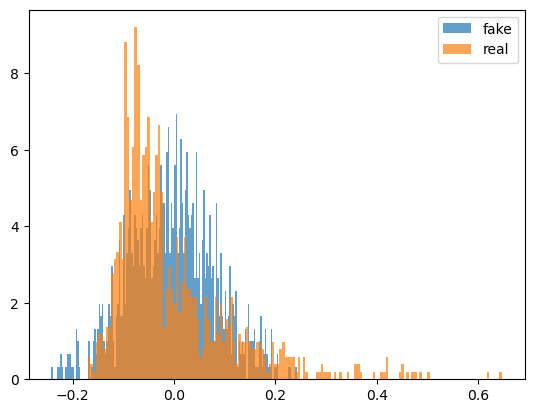

Epoch 1


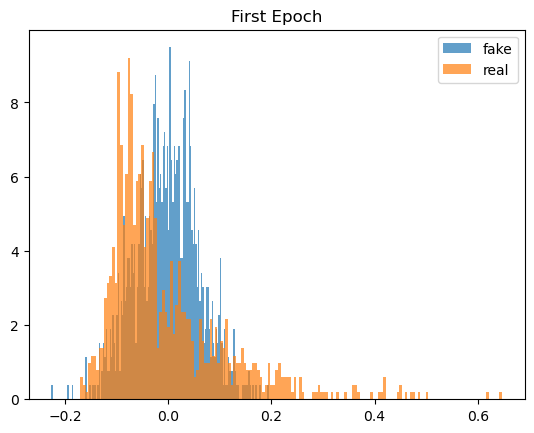

Epoch: 1 Loss D.: -0.06102097034454346 Loss G.: 0.023936523124575615 KL Divergence.: 0.8963580620288949
Epoch 1


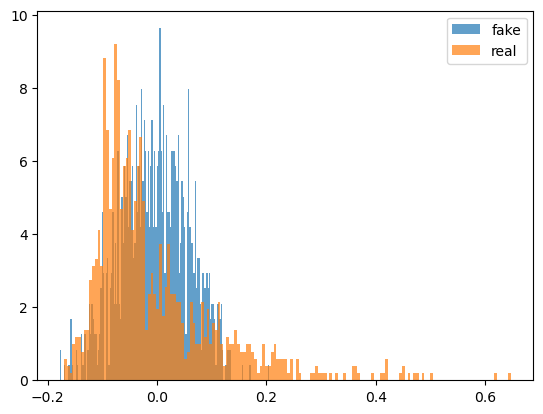

Epoch: 2 Loss D.: -0.05757144093513489 Loss G.: 0.02352198213338852 KL Divergence.: 1.3740157319116793
Epoch: 3 Loss D.: -0.05069517716765404 Loss G.: 0.019596800208091736 KL Divergence.: 0.7472813086022514
Epoch 3


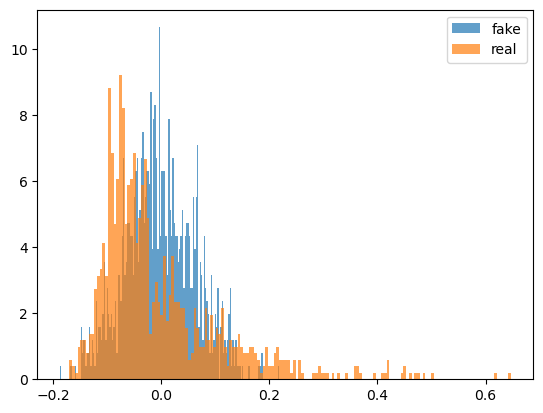

Epoch: 4 Loss D.: -0.05201740935444832 Loss G.: 0.013963866047561169 KL Divergence.: 1.3798115676733111
Epoch: 5 Loss D.: -0.03633255138993263 Loss G.: 0.014715038239955902 KL Divergence.: 3.207207021375556
Epoch: 6 Loss D.: -0.047152187675237656 Loss G.: 0.009787200950086117 KL Divergence.: 3.1446844894503707
Epoch: 7 Loss D.: -0.03962074965238571 Loss G.: 0.008880036883056164 KL Divergence.: 2.5117782506943893
Epoch: 8 Loss D.: -0.03784932568669319 Loss G.: 0.007798879407346249 KL Divergence.: 1.5897511066488204
Epoch: 9 Loss D.: -0.036919381469488144 Loss G.: 0.008323204703629017 KL Divergence.: 2.848638796629188
Epoch: 10 Loss D.: -0.040527842938899994 Loss G.: 0.003741760738193989 KL Divergence.: 0.8097573944587105
Epoch 10


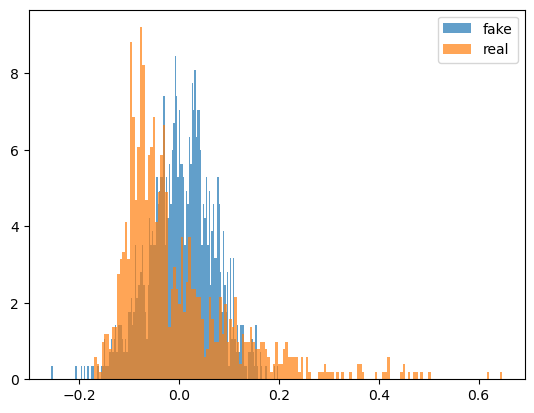

Epoch: 11 Loss D.: -0.03553878888487816 Loss G.: 0.0035066064447164536 KL Divergence.: 3.4310539022302304
Epoch: 12 Loss D.: -0.03519634157419205 Loss G.: 0.0040564946830272675 KL Divergence.: 1.8975413420931593
Epoch: 13 Loss D.: -0.03697199746966362 Loss G.: 0.003819122212007642 KL Divergence.: 5.075490096379443
Epoch: 14 Loss D.: -0.03318263217806816 Loss G.: 0.003625252516940236 KL Divergence.: 2.822815367161186
Epoch: 15 Loss D.: -0.037241823971271515 Loss G.: 0.004174005705863237 KL Divergence.: 5.357186816928049
Epoch: 16 Loss D.: -0.035609737038612366 Loss G.: 0.006734367925673723 KL Divergence.: 2.2629748208734712
Epoch: 17 Loss D.: -0.03655075281858444 Loss G.: 0.005388441029936075 KL Divergence.: 4.01420560745822
Epoch: 18 Loss D.: -0.030982960015535355 Loss G.: 0.004589984659105539 KL Divergence.: 5.561501826654828
Epoch: 19 Loss D.: -0.02906738966703415 Loss G.: 0.002941267564892769 KL Divergence.: 5.254499055878271
Epoch: 20 Loss D.: -0.027867062017321587 Loss G.: 0.00191

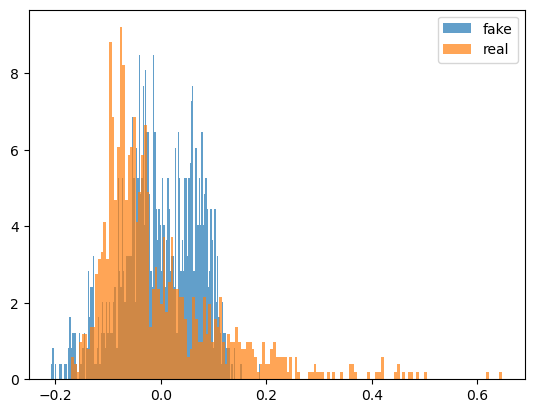

Epoch: 38 Loss D.: -0.02750840038061142 Loss G.: 0.0011790618300437927 KL Divergence.: 4.432622033239069
Epoch: 39 Loss D.: -0.03214358165860176 Loss G.: 0.003974087070673704 KL Divergence.: 4.694087293972995
Epoch: 40 Loss D.: -0.03133179992437363 Loss G.: -0.0003234290052205324 KL Divergence.: 3.2086060637579807
Epoch: 41 Loss D.: -0.023694882169365883 Loss G.: -0.0012181589845567942 KL Divergence.: 5.382382270877336
Epoch: 42 Loss D.: -0.02831920236349106 Loss G.: -0.004900982137769461 KL Divergence.: 4.236749368024341
Epoch: 43 Loss D.: -0.038212813436985016 Loss G.: -0.005435463041067123 KL Divergence.: 5.276060915608429
Epoch: 44 Loss D.: -0.032797232270240784 Loss G.: 0.00026859444915317 KL Divergence.: 1.5779090873186106
Epoch: 45 Loss D.: -0.02956313081085682 Loss G.: 0.0007742065936326981 KL Divergence.: 2.6148365590417493
Epoch: 46 Loss D.: -0.04486451297998428 Loss G.: 0.0011373271699994802 KL Divergence.: 0.8608363169267983
Epoch 46


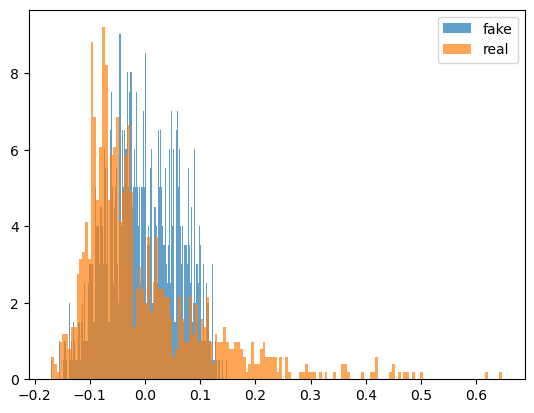

Epoch: 47 Loss D.: -0.0379069559276104 Loss G.: -0.0005904774880036712 KL Divergence.: 1.515826731121541
Epoch: 48 Loss D.: -0.030247598886489868 Loss G.: -0.00021363969426602125 KL Divergence.: 1.7572067136829022
Epoch: 49 Loss D.: -0.03360555320978165 Loss G.: -0.0015221587382256985 KL Divergence.: 2.5193048063661365
Epoch: 50 Loss D.: -0.0335676409304142 Loss G.: -0.0007217699894681573 KL Divergence.: 2.9398131086319914
Epoch: 51 Loss D.: -0.03319738432765007 Loss G.: -0.00033515470568090677 KL Divergence.: 2.803134502537639
Epoch: 52 Loss D.: -0.03091016411781311 Loss G.: -0.0031652511097490788 KL Divergence.: 4.548550526986036
Epoch: 53 Loss D.: -0.031578775495290756 Loss G.: -0.0037295531947165728 KL Divergence.: 0.5538814348544691
Epoch 53


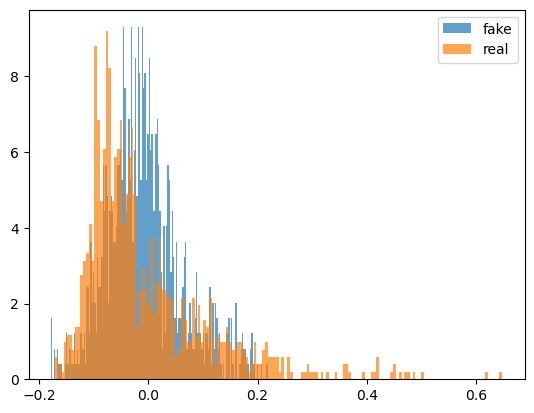

Epoch: 54 Loss D.: -0.03478946164250374 Loss G.: 0.0033086149487644434 KL Divergence.: 3.168919882294584
Epoch: 55 Loss D.: -0.0409577451646328 Loss G.: 0.0004944212851114571 KL Divergence.: 4.134837747686342
Epoch: 56 Loss D.: -0.028440946713089943 Loss G.: -0.0016606863355264068 KL Divergence.: 5.021388836227334
Epoch: 57 Loss D.: -0.02953670732676983 Loss G.: -0.0013887842651456594 KL Divergence.: 5.962281499189146
Epoch: 58 Loss D.: -0.03383167088031769 Loss G.: -0.0016495895106345415 KL Divergence.: 5.1391734581002595
Epoch: 59 Loss D.: -0.031170396134257317 Loss G.: 0.003400803543627262 KL Divergence.: 5.2679847156877635
Epoch: 60 Loss D.: -0.03789406269788742 Loss G.: 0.0017540089320391417 KL Divergence.: 4.136309544833259
Epoch: 61 Loss D.: -0.03630419820547104 Loss G.: 0.005972918123006821 KL Divergence.: 4.818559752079322
Epoch: 62 Loss D.: -0.03277409449219704 Loss G.: 0.0002157147682737559 KL Divergence.: 2.4117437481810446
Epoch: 63 Loss D.: -0.030253872275352478 Loss G.: 

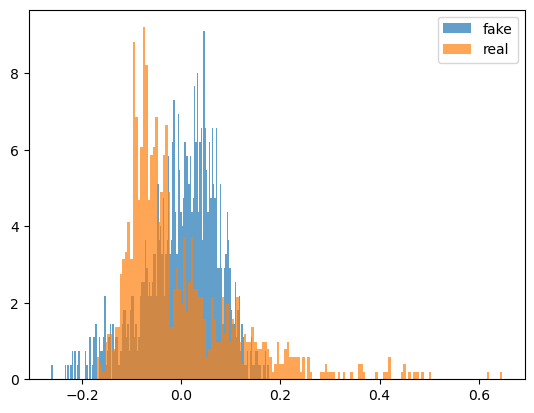

Epoch: 67 Loss D.: -0.04116958752274513 Loss G.: -0.0009545091888867319 KL Divergence.: 0.5529935801677923
Epoch 67


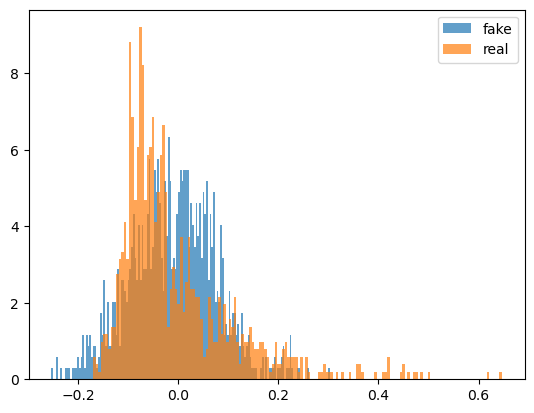

Epoch: 68 Loss D.: -0.032206661999225616 Loss G.: -0.0008389524882659316 KL Divergence.: 5.053549017699609
Epoch: 69 Loss D.: -0.033917445689439774 Loss G.: 0.001505075255408883 KL Divergence.: 0.39421821659863404
Epoch 69


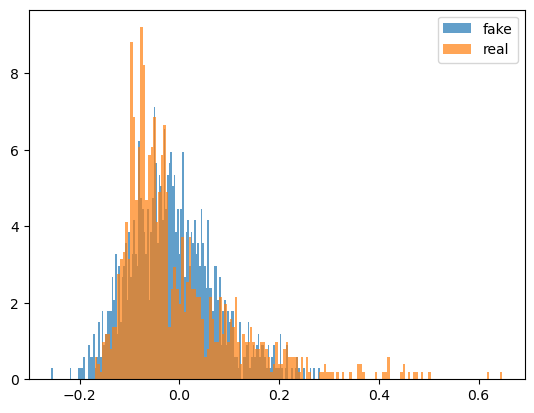

Epoch: 70 Loss D.: -0.03200014680624008 Loss G.: -5.206806235946715e-06 KL Divergence.: 2.7431957050543785
Epoch: 71 Loss D.: -0.028381992131471634 Loss G.: 0.0007601118413731456 KL Divergence.: 3.5219178683958274
Epoch: 72 Loss D.: -0.03476864844560623 Loss G.: -0.000752417603507638 KL Divergence.: 0.598507921129495
Epoch 72


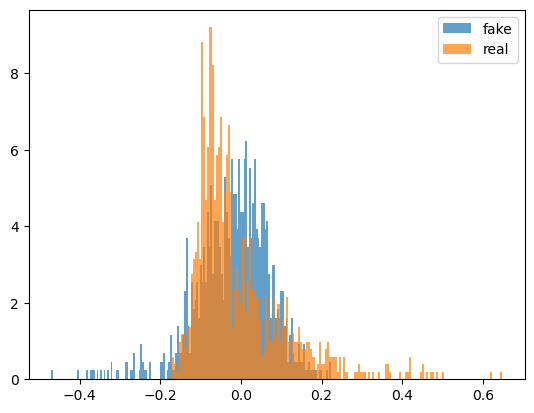

Epoch: 73 Loss D.: -0.03600442036986351 Loss G.: -0.0011406977428123355 KL Divergence.: 1.6827828355588261
Epoch: 74 Loss D.: -0.04139675572514534 Loss G.: 0.00027066643815487623 KL Divergence.: 2.222517276425425
Epoch: 75 Loss D.: -0.03495984151959419 Loss G.: 0.0023793471045792103 KL Divergence.: 4.4991015717155385
Epoch: 76 Loss D.: -0.03775428980588913 Loss G.: -0.0009205939713865519 KL Divergence.: 5.246375272885247
Epoch: 77 Loss D.: -0.03827550262212753 Loss G.: -0.008492057211697102 KL Divergence.: 3.872472716538258
Epoch: 78 Loss D.: -0.0356634184718132 Loss G.: 0.001448728609830141 KL Divergence.: 2.726336008768577
Epoch: 79 Loss D.: -0.031021812930703163 Loss G.: 0.0036026318557560444 KL Divergence.: 1.442323969662364
Epoch: 80 Loss D.: -0.02722020447254181 Loss G.: -0.0008365573594346642 KL Divergence.: 4.867655267202976
Epoch: 81 Loss D.: -0.03416067734360695 Loss G.: 0.001792245195247233 KL Divergence.: 4.738037934073193
Epoch: 82 Loss D.: -0.027245238423347473 Loss G.: -

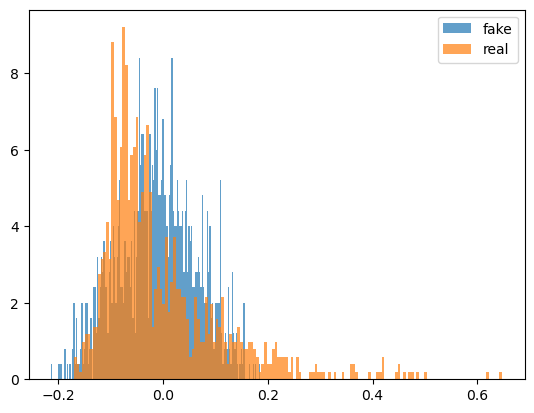

Epoch: 83 Loss D.: -0.03466431424021721 Loss G.: -0.0028765033930540085 KL Divergence.: 2.150773232977906
Epoch: 84 Loss D.: -0.03940475359559059 Loss G.: -0.005530048161745071 KL Divergence.: 1.2983158336244598
Epoch: 85 Loss D.: -0.028398629277944565 Loss G.: -0.0015353409107774496 KL Divergence.: 2.607323854764463
Epoch: 86 Loss D.: -0.041708823293447495 Loss G.: -0.004614890553057194 KL Divergence.: 5.288046950619636
Epoch: 87 Loss D.: -0.027264932170510292 Loss G.: 0.0015533894766122103 KL Divergence.: 0.7799129870849797
Epoch 87


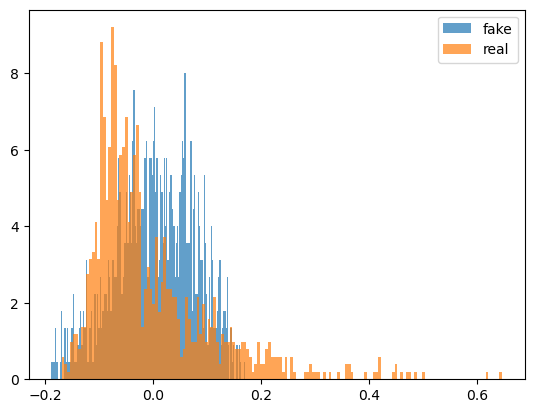

Epoch: 88 Loss D.: -0.03538806736469269 Loss G.: 0.002708720276132226 KL Divergence.: 3.7514338700249388
Epoch: 89 Loss D.: -0.03410250321030617 Loss G.: 0.0017601284198462963 KL Divergence.: 1.190093291864064
Epoch: 90 Loss D.: -0.03551032766699791 Loss G.: 0.00032040008227340877 KL Divergence.: 3.6319009045912285
Epoch: 91 Loss D.: -0.032742422074079514 Loss G.: 0.0014660954475402832 KL Divergence.: 0.9653057184861356
Epoch 91


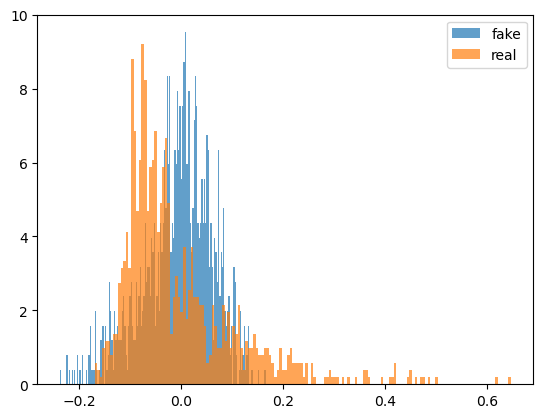

Epoch: 92 Loss D.: -0.03455832228064537 Loss G.: -0.001723537570796907 KL Divergence.: 5.340309692754364
Epoch: 93 Loss D.: -0.03191781044006348 Loss G.: 0.0007164638955146074 KL Divergence.: 3.7050619886633536
Epoch: 94 Loss D.: -0.03575756773352623 Loss G.: 9.29566886043176e-05 KL Divergence.: 5.527459105222279
Epoch: 95 Loss D.: -0.030859870836138725 Loss G.: 8.707487722858787e-05 KL Divergence.: 1.4549323636528493
Epoch: 96 Loss D.: -0.025358738377690315 Loss G.: -0.002780037932097912 KL Divergence.: 1.1118096690089514
Epoch: 97 Loss D.: -0.03342999890446663 Loss G.: -0.0006498831789940596 KL Divergence.: 6.040469550036655
Epoch: 98 Loss D.: -0.029461326077580452 Loss G.: 0.0008070303592830896 KL Divergence.: 4.1932303614611595
Epoch: 99 Loss D.: -0.029387909919023514 Loss G.: -0.0026176380924880505 KL Divergence.: 0.6296051757632629
Epoch 99


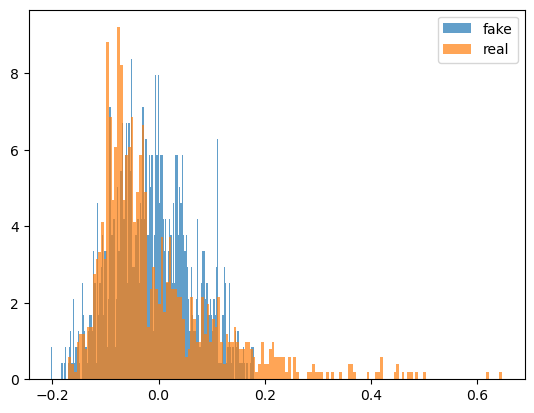

Epoch: 100 Loss D.: -0.027149351313710213 Loss G.: -0.00115862931124866 KL Divergence.: 5.273072191972217
Epoch: 101 Loss D.: -0.026790298521518707 Loss G.: -0.0004423460050020367 KL Divergence.: 1.6979973663605672
Epoch: 102 Loss D.: -0.031948354095220566 Loss G.: 7.955904584378004e-05 KL Divergence.: 1.6573168997868977
Epoch: 103 Loss D.: -0.0442008376121521 Loss G.: -0.00046718918019905686 KL Divergence.: 2.745021044658281
Epoch: 104 Loss D.: -0.03386872261762619 Loss G.: -0.0028149867430329323 KL Divergence.: 5.641442863789196
Epoch: 105 Loss D.: -0.027127167209982872 Loss G.: 0.0029227850027382374 KL Divergence.: 2.9163412964759114
Epoch: 106 Loss D.: -0.030256127938628197 Loss G.: 0.0034709605388343334 KL Divergence.: 4.409092372417657
Epoch: 107 Loss D.: -0.028156127780675888 Loss G.: -0.00021878615370951593 KL Divergence.: 1.9586620062992164
Epoch: 108 Loss D.: -0.03465826436877251 Loss G.: -0.0016485266387462616 KL Divergence.: 5.147299851719775
Epoch: 109 Loss D.: -0.03622578

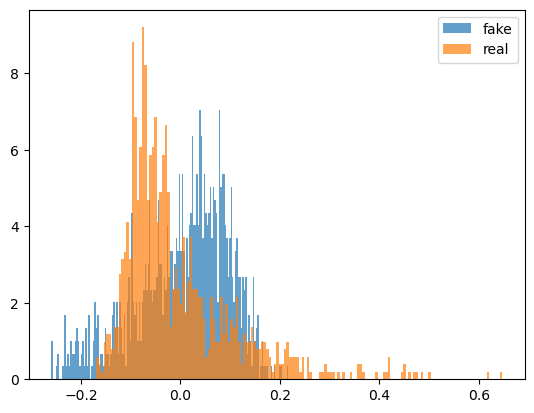

Epoch: 112 Loss D.: -0.03309236466884613 Loss G.: -0.0004720893339253962 KL Divergence.: 3.122761055874785
Epoch: 113 Loss D.: -0.03520926460623741 Loss G.: 0.00030000164406374097 KL Divergence.: 5.884913844695884
Epoch: 114 Loss D.: -0.03980833292007446 Loss G.: -0.002045190893113613 KL Divergence.: 1.187161965403913
Epoch: 115 Loss D.: -0.032066460698843 Loss G.: 0.0006331970798783004 KL Divergence.: 1.1536450052264269
Epoch: 116 Loss D.: -0.026518143713474274 Loss G.: 0.0002900779072660953 KL Divergence.: 5.403135834350266
Epoch: 117 Loss D.: -0.028481004759669304 Loss G.: 0.00041304557817056775 KL Divergence.: 2.134160273518722
Epoch: 118 Loss D.: -0.032065074890851974 Loss G.: -0.00019759725546464324 KL Divergence.: 3.6627654786110595
Epoch: 119 Loss D.: -0.027240244671702385 Loss G.: -0.0015782022383064032 KL Divergence.: 5.728247901772238
Epoch: 120 Loss D.: -0.03382828086614609 Loss G.: 0.0002589629148133099 KL Divergence.: 4.853219077419061
Epoch: 121 Loss D.: -0.0466869547963

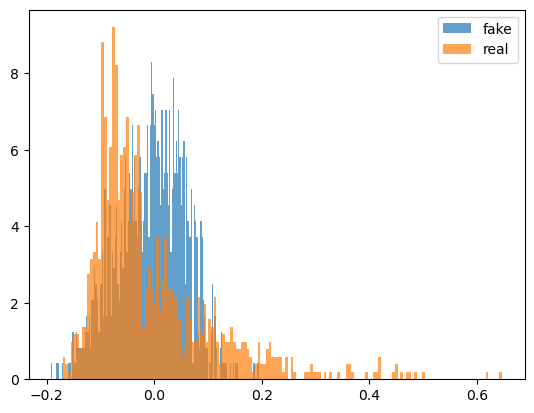

Epoch: 128 Loss D.: -0.02583807334303856 Loss G.: 0.00015714782057330012 KL Divergence.: 0.522431759140193
Epoch 128


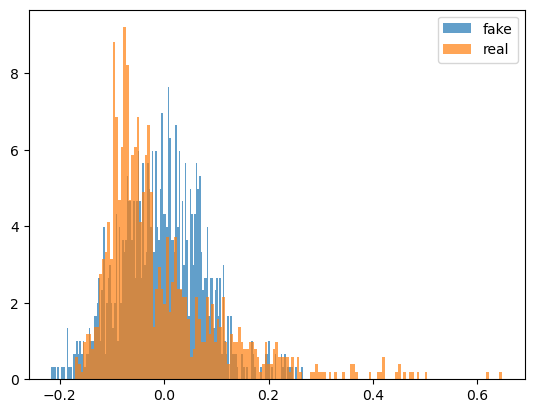

Epoch: 129 Loss D.: -0.02932530641555786 Loss G.: -0.002908139955252409 KL Divergence.: 1.7144941594196401
Epoch: 130 Loss D.: -0.036994569003582 Loss G.: -0.002189185470342636 KL Divergence.: 2.7440790109322157
Epoch: 131 Loss D.: -0.027377713471651077 Loss G.: -0.00048583457828499377 KL Divergence.: 0.5374835973724976
Epoch 131


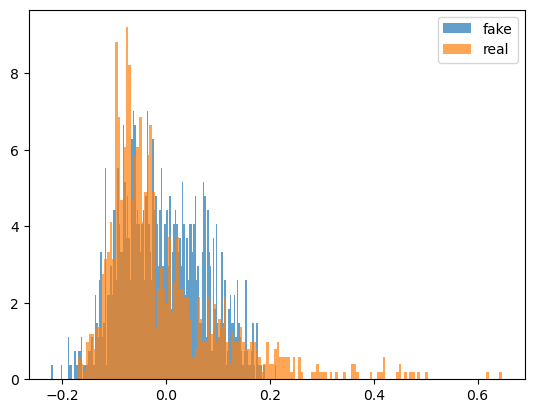

Epoch: 132 Loss D.: -0.028828546404838562 Loss G.: -0.00022379567963071167 KL Divergence.: 5.338733543001844
Epoch: 133 Loss D.: -0.03845348209142685 Loss G.: 0.0016041360795497894 KL Divergence.: 5.444216623306525
Epoch: 134 Loss D.: -0.029720373451709747 Loss G.: -0.000991567736491561 KL Divergence.: 6.203239406760665
Epoch: 135 Loss D.: -0.03006790578365326 Loss G.: 0.002223443239927292 KL Divergence.: 1.5463347239879248
Epoch: 136 Loss D.: -0.03269272297620773 Loss G.: -0.00015615759184584022 KL Divergence.: 3.5088318611374136
Epoch: 137 Loss D.: -0.03298317268490791 Loss G.: -0.0005228528752923012 KL Divergence.: 0.6177301124781173
Epoch 137


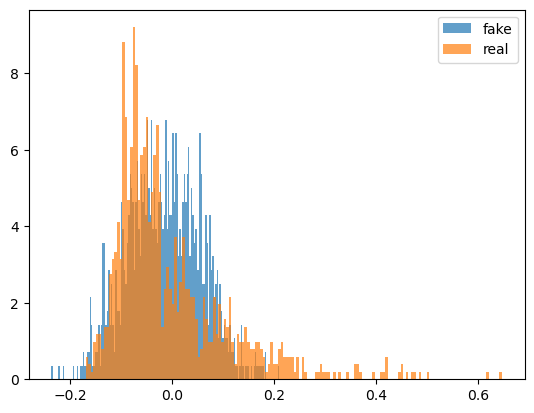

Epoch: 138 Loss D.: -0.032535187900066376 Loss G.: -0.00011487521987874061 KL Divergence.: 5.60022497690278
Epoch: 139 Loss D.: -0.02856476604938507 Loss G.: -0.0008000335656106472 KL Divergence.: 1.6852128965571396
Epoch: 140 Loss D.: -0.03767027333378792 Loss G.: -0.003795662196353078 KL Divergence.: 1.262871315744175
Epoch: 141 Loss D.: -0.02923419326543808 Loss G.: -0.0026292826514691114 KL Divergence.: 5.618974259861278
Epoch: 142 Loss D.: -0.03286254405975342 Loss G.: -0.0020379151683300734 KL Divergence.: 2.002531234086398
Epoch: 143 Loss D.: -0.02969808131456375 Loss G.: -0.0009050347143784165 KL Divergence.: 0.40236666726252585
Epoch 143


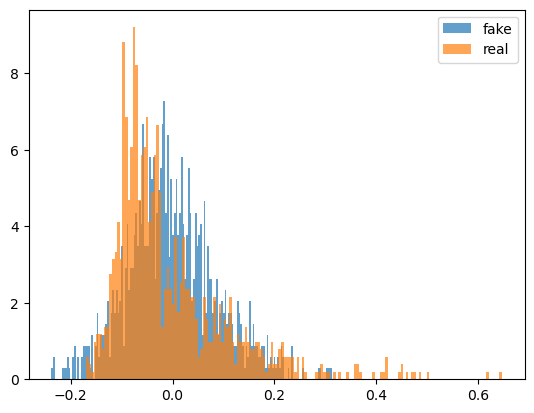

Epoch: 144 Loss D.: -0.042867932468652725 Loss G.: -0.0002185144549002871 KL Divergence.: 1.2517349172309755
Epoch: 145 Loss D.: -0.031190399080514908 Loss G.: -0.0010973064927384257 KL Divergence.: 5.899408877979138
Epoch: 146 Loss D.: -0.031271785497665405 Loss G.: 0.0009929101215675473 KL Divergence.: 0.7313570942927142
Epoch 146


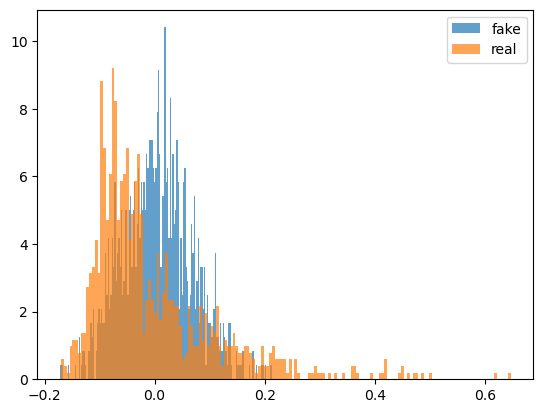

Epoch: 147 Loss D.: -0.03213970363140106 Loss G.: 0.0002822665555868298 KL Divergence.: 0.47311137761917993
Epoch 147


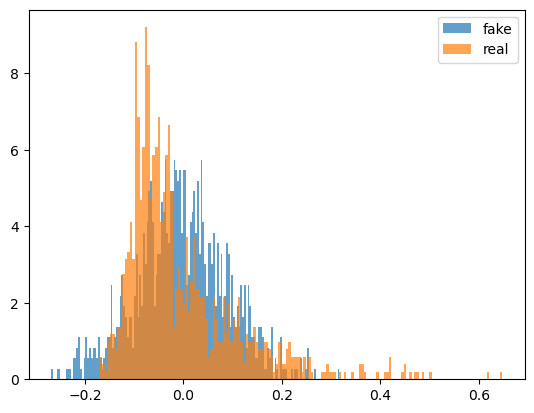

Epoch: 148 Loss D.: -0.027938032522797585 Loss G.: -0.002152073662728071 KL Divergence.: 2.8455937719428137
Epoch: 149 Loss D.: -0.028607001528143883 Loss G.: -0.0013573612086474895 KL Divergence.: 5.488478181422913
Epoch: 150 Loss D.: -0.037115611135959625 Loss G.: -0.0003812460054177791 KL Divergence.: 3.586499889031552
Epoch: 151 Loss D.: -0.025946561247110367 Loss G.: 0.00019758327107410878 KL Divergence.: 1.5086314636884666
Epoch: 152 Loss D.: -0.027649469673633575 Loss G.: 0.0015816438244655728 KL Divergence.: 0.8360596725991961
Epoch 152


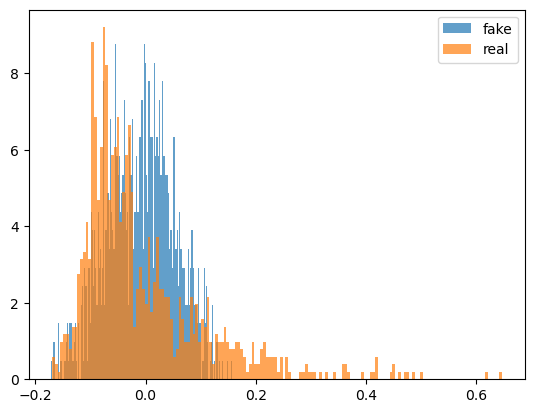

Epoch: 153 Loss D.: -0.031243134289979935 Loss G.: 0.0015750819584354758 KL Divergence.: 1.2207333565090406
Epoch: 154 Loss D.: -0.0318453274667263 Loss G.: -0.0017386917024850845 KL Divergence.: 1.4576500002825576
Epoch: 155 Loss D.: -0.03982260823249817 Loss G.: -0.004386839922517538 KL Divergence.: 5.314493558694
Epoch: 156 Loss D.: -0.026957117021083832 Loss G.: -0.0023852097801864147 KL Divergence.: 5.525295265280127
Epoch: 157 Loss D.: -0.027414223179221153 Loss G.: 0.0003489583032205701 KL Divergence.: 0.8422106433738561
Epoch 157


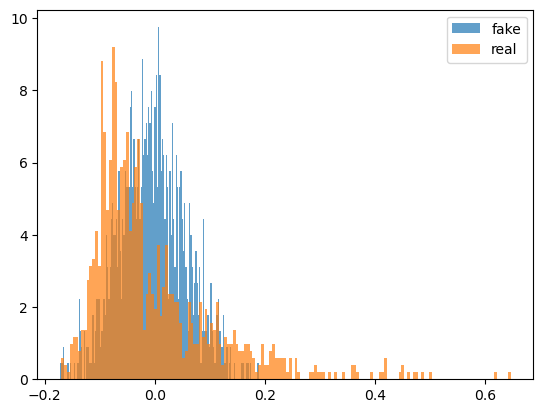

Epoch: 158 Loss D.: -0.02839403972029686 Loss G.: 0.00416745338588953 KL Divergence.: 2.5920412600813623
Epoch: 159 Loss D.: -0.03365981951355934 Loss G.: -0.0044115702621638775 KL Divergence.: 6.008047347566652
Epoch: 160 Loss D.: -0.03575717285275459 Loss G.: -0.0004113409959245473 KL Divergence.: 5.787253161662167
Epoch: 161 Loss D.: -0.04368755966424942 Loss G.: 0.0018189593683928251 KL Divergence.: 1.7276580979588532
Epoch: 162 Loss D.: -0.026778465136885643 Loss G.: 0.001707218587398529 KL Divergence.: 3.0517674790908313
Epoch: 163 Loss D.: -0.030656898394227028 Loss G.: 0.00091412483016029 KL Divergence.: 4.563806641529708
Epoch: 164 Loss D.: -0.02968822978436947 Loss G.: -0.0006652808515354991 KL Divergence.: 1.3132548822627645
Epoch: 165 Loss D.: -0.030217859894037247 Loss G.: -0.0016234808135777712 KL Divergence.: 5.593360626398109
Epoch: 166 Loss D.: -0.03245824947953224 Loss G.: -0.0007811732357367873 KL Divergence.: 5.877162207898041
Epoch: 167 Loss D.: -0.0344682298600673

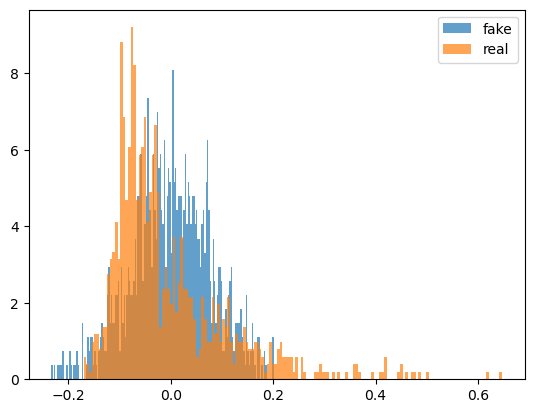

Epoch: 168 Loss D.: -0.030132507905364037 Loss G.: -0.002491673221811652 KL Divergence.: 4.192033136642112
Epoch: 169 Loss D.: -0.03608804568648338 Loss G.: -0.0019259955734014511 KL Divergence.: 4.380979304176726
Epoch: 170 Loss D.: -0.022235151380300522 Loss G.: -0.00154814962297678 KL Divergence.: 4.2518577747303095
Epoch: 171 Loss D.: -0.03206579014658928 Loss G.: 0.0021342216059565544 KL Divergence.: 6.091667084226999
Epoch: 172 Loss D.: -0.03125687688589096 Loss G.: 0.0012465913314372301 KL Divergence.: 3.1341932068270486
Epoch: 173 Loss D.: -0.02643939107656479 Loss G.: -0.0005398071371018887 KL Divergence.: 2.3846640683311566
Epoch: 174 Loss D.: -0.03288329765200615 Loss G.: -0.0014590732753276825 KL Divergence.: 6.058543761869534
Epoch: 175 Loss D.: -0.033085472881793976 Loss G.: -0.0008414295734837651 KL Divergence.: 0.9106028018707947
Epoch 175


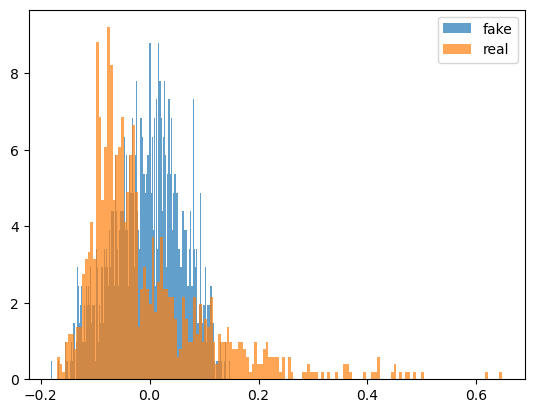

Epoch: 176 Loss D.: -0.030457664281129837 Loss G.: -0.001047596801072359 KL Divergence.: 0.6256352604298323
Epoch 176


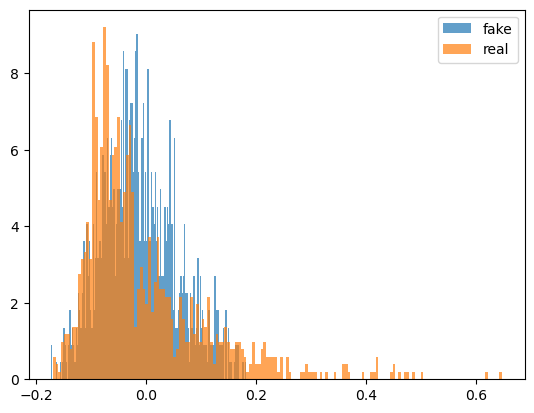

Epoch: 177 Loss D.: -0.0335315577685833 Loss G.: -6.010435754433274e-05 KL Divergence.: 0.38910398147190006
Epoch 177


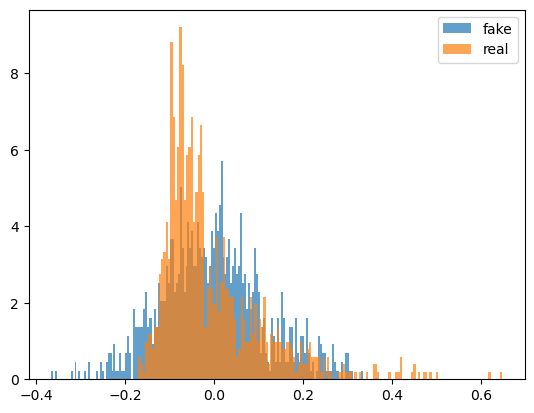

Epoch: 178 Loss D.: -0.033437177538871765 Loss G.: 0.00013426042278297246 KL Divergence.: 4.415433376860235
Epoch: 179 Loss D.: -0.031549274921417236 Loss G.: 0.0010950872674584389 KL Divergence.: 5.301862901552672
Epoch: 180 Loss D.: -0.03262854740023613 Loss G.: -0.000951597816310823 KL Divergence.: 0.9871388078241048
Epoch 180


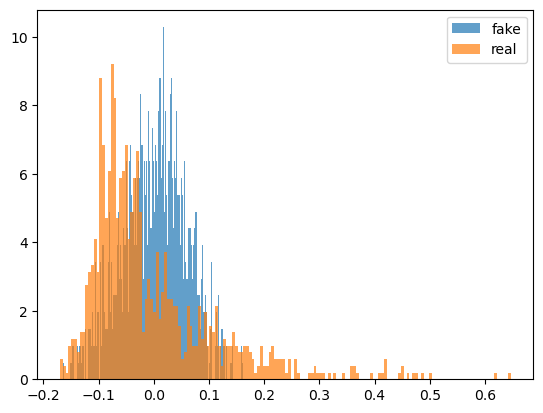

Epoch: 181 Loss D.: -0.028476253151893616 Loss G.: -0.001065051183104515 KL Divergence.: 5.948608638946504
Epoch: 182 Loss D.: -0.032428670674562454 Loss G.: 0.002569857519119978 KL Divergence.: 5.230062032910714
Epoch: 183 Loss D.: -0.0263077262789011 Loss G.: 0.0010957687627524137 KL Divergence.: 5.560841878298536
Epoch: 184 Loss D.: -0.032599568367004395 Loss G.: 5.978537956252694e-06 KL Divergence.: 5.818723029538283
Epoch: 185 Loss D.: -0.03284323215484619 Loss G.: 0.0002436478971503675 KL Divergence.: 2.5703598500426663
Epoch: 186 Loss D.: -0.02837406098842621 Loss G.: -0.0009116720757447183 KL Divergence.: 3.630180929192691
Epoch: 187 Loss D.: -0.03208284080028534 Loss G.: 0.0009550589602440596 KL Divergence.: 0.9186336345608195
Epoch 187


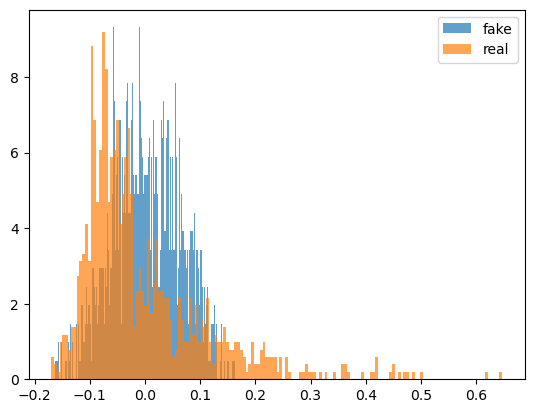

Epoch: 188 Loss D.: -0.026637393981218338 Loss G.: 0.0008281736518256366 KL Divergence.: 6.044984920603056
Epoch: 189 Loss D.: -0.03148486092686653 Loss G.: -0.0007724910974502563 KL Divergence.: 1.4720703559896409
Epoch: 190 Loss D.: -0.02771027758717537 Loss G.: -0.002052303170785308 KL Divergence.: 3.6015435414116883
Epoch: 191 Loss D.: -0.027255844324827194 Loss G.: 0.0011371932923793793 KL Divergence.: 4.120751529098794
Epoch: 192 Loss D.: -0.034103184938430786 Loss G.: -0.0007933178567327559 KL Divergence.: 4.956537387587298
Epoch: 193 Loss D.: -0.032053060829639435 Loss G.: -0.009424868039786816 KL Divergence.: 4.149059788935718
Epoch: 194 Loss D.: -0.0417790450155735 Loss G.: -0.007346295285969973 KL Divergence.: 5.753179874858994
Epoch: 195 Loss D.: -0.03273770958185196 Loss G.: 0.00013262646098155528 KL Divergence.: 5.315507116512318
Epoch: 196 Loss D.: -0.03477365896105766 Loss G.: 0.0003512722614686936 KL Divergence.: 2.1662533605597476
Epoch: 197 Loss D.: -0.03064732439815

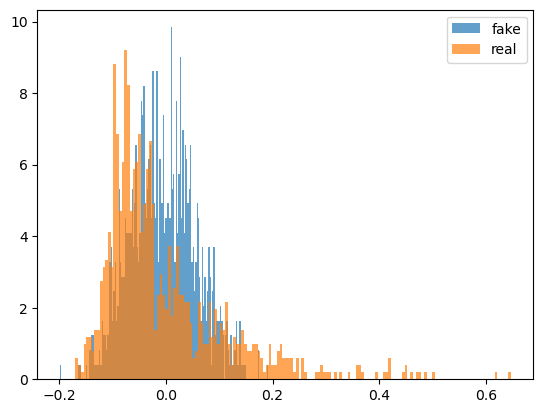

Epoch: 199 Loss D.: -0.03267628327012062 Loss G.: 0.00038868747651576996 KL Divergence.: 4.385414717603504
Epoch: 200 Loss D.: -0.028374245390295982 Loss G.: -0.0006653618765994906 KL Divergence.: 0.9942040079133909
Epoch 200


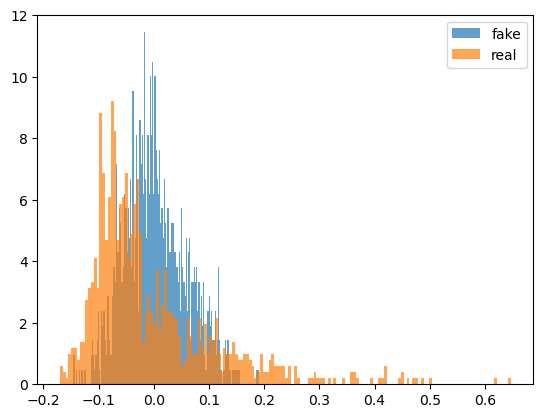

Epoch: 201 Loss D.: -0.03621545061469078 Loss G.: -0.001045468496158719 KL Divergence.: 1.8857691463737993
Epoch: 202 Loss D.: -0.030003666877746582 Loss G.: 0.0003558738681022078 KL Divergence.: 4.859093225815052
Epoch: 203 Loss D.: -0.0278428066521883 Loss G.: 0.001187985297292471 KL Divergence.: 1.6479704565545454
Epoch: 204 Loss D.: -0.028652282431721687 Loss G.: -0.0005698544555343688 KL Divergence.: 5.590157862157592
Epoch: 205 Loss D.: -0.036997660994529724 Loss G.: -0.003800606355071068 KL Divergence.: 5.3015209386089275
Epoch: 206 Loss D.: -0.030485933646559715 Loss G.: 0.001584584009833634 KL Divergence.: 2.8783582399721555
Epoch: 207 Loss D.: -0.04399959743022919 Loss G.: 0.000441205280367285 KL Divergence.: 0.43275817640623526
Epoch 207


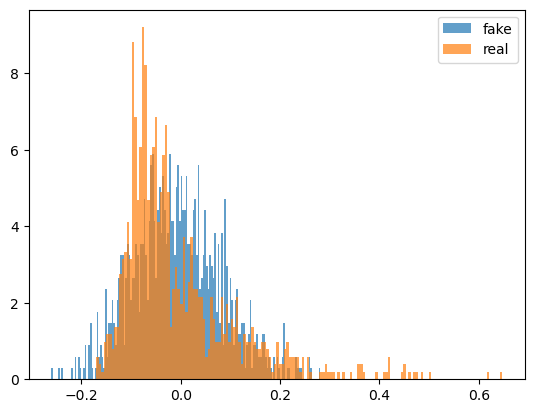

Epoch: 208 Loss D.: -0.028895407915115356 Loss G.: -0.00015886040637269616 KL Divergence.: 4.820202848764547
Epoch: 209 Loss D.: -0.028613699600100517 Loss G.: 0.0016779113793745637 KL Divergence.: 0.5994445407282751
Epoch 209


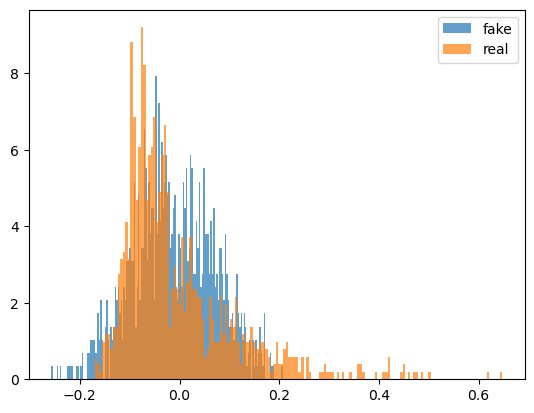

Epoch: 210 Loss D.: -0.031755607575178146 Loss G.: 0.0007312190718948841 KL Divergence.: 0.7366369480412956
Epoch 210


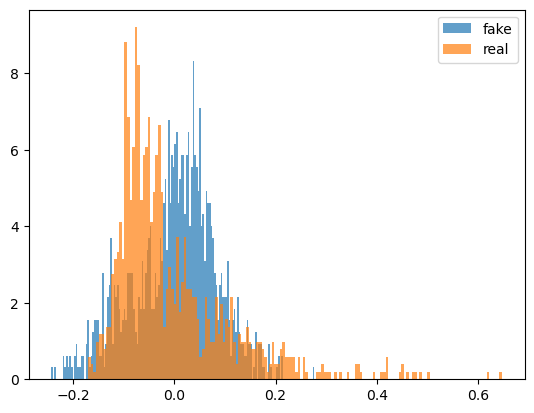

Epoch: 211 Loss D.: -0.03314622864127159 Loss G.: -0.00034355639945715666 KL Divergence.: 0.8333515465221866
Epoch 211


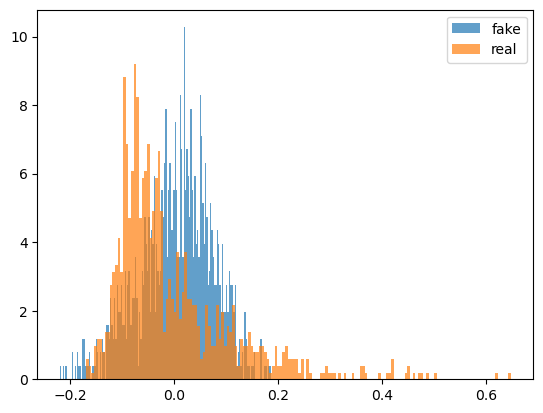

Epoch: 212 Loss D.: -0.03699745237827301 Loss G.: -0.0014688686933368444 KL Divergence.: 0.9563833106020052
Epoch 212


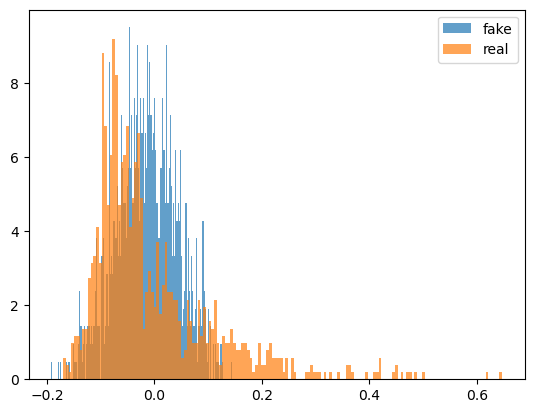

Epoch: 213 Loss D.: -0.02773151732981205 Loss G.: -0.002417056355625391 KL Divergence.: 5.826234516583384
Epoch: 214 Loss D.: -0.025718092918395996 Loss G.: -0.0010185627033933997 KL Divergence.: 4.746526477458756
Epoch: 215 Loss D.: -0.03336716815829277 Loss G.: -0.00013504171511158347 KL Divergence.: 5.324822336019302
Epoch: 216 Loss D.: -0.03522763401269913 Loss G.: -0.0008843671530485153 KL Divergence.: 4.877852252940115
Epoch: 217 Loss D.: -0.031407106667757034 Loss G.: 0.004236018750816584 KL Divergence.: 4.142269958386354
Epoch: 218 Loss D.: -0.031577952206134796 Loss G.: 0.004113859497010708 KL Divergence.: 4.889413166430687
Epoch: 219 Loss D.: -0.02871275134384632 Loss G.: -0.00022374225954990834 KL Divergence.: 1.7764926571741295
Epoch: 220 Loss D.: -0.03117046132683754 Loss G.: 0.0006516648572869599 KL Divergence.: 4.887991444481665
Epoch: 221 Loss D.: -0.027194662019610405 Loss G.: 0.00023561343550682068 KL Divergence.: 3.530907253728987
Epoch: 222 Loss D.: -0.0348697975277

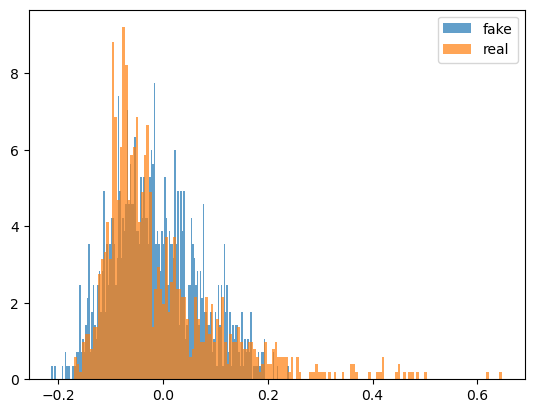

Epoch: 231 Loss D.: -0.030421214178204536 Loss G.: 0.00015203672228381038 KL Divergence.: 0.9872258178680998
Epoch 231


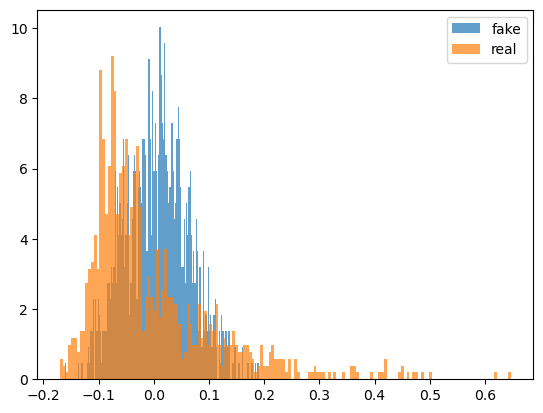

Epoch: 232 Loss D.: -0.03459175303578377 Loss G.: 0.0015425101155415177 KL Divergence.: 1.0540274084962586
Epoch: 233 Loss D.: -0.027754466980695724 Loss G.: 3.0314913601614535e-05 KL Divergence.: 5.472872728166502
Epoch: 234 Loss D.: -0.04375027120113373 Loss G.: -0.002687575062736869 KL Divergence.: 5.153263613086986
Epoch: 235 Loss D.: -0.033038727939128876 Loss G.: 0.0006862248992547393 KL Divergence.: 1.9372960022140069
Epoch: 236 Loss D.: -0.03396163135766983 Loss G.: 0.003449557116255164 KL Divergence.: 5.036253436237747
Epoch: 237 Loss D.: -0.03190944716334343 Loss G.: 0.002051351359114051 KL Divergence.: 4.942151131858248
Epoch: 238 Loss D.: -0.029024533927440643 Loss G.: -0.0021280685905367136 KL Divergence.: 4.833543263650926
Epoch: 239 Loss D.: -0.02722286619246006 Loss G.: 0.0013221005210652947 KL Divergence.: 5.8247673704085114
Epoch: 240 Loss D.: -0.028638511896133423 Loss G.: -0.0006149291875772178 KL Divergence.: 5.153235505296053
Epoch: 241 Loss D.: -0.027445398271083

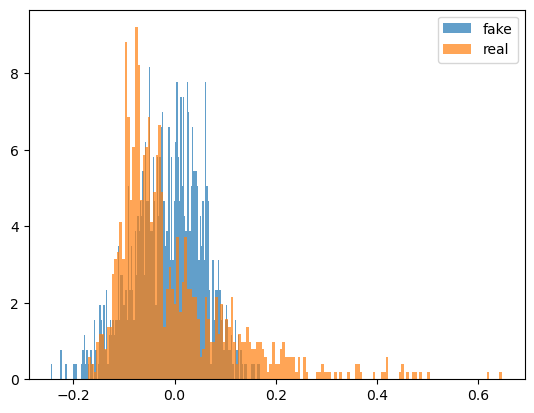

Epoch: 252 Loss D.: -0.03075069934129715 Loss G.: 0.0033779998775571585 KL Divergence.: 5.332395373447055
Epoch: 253 Loss D.: -0.031485676765441895 Loss G.: 0.000932669616304338 KL Divergence.: 5.04001965157444
Epoch: 254 Loss D.: -0.026063477620482445 Loss G.: 0.0002873428456950933 KL Divergence.: 0.8987009827733808
Epoch 254


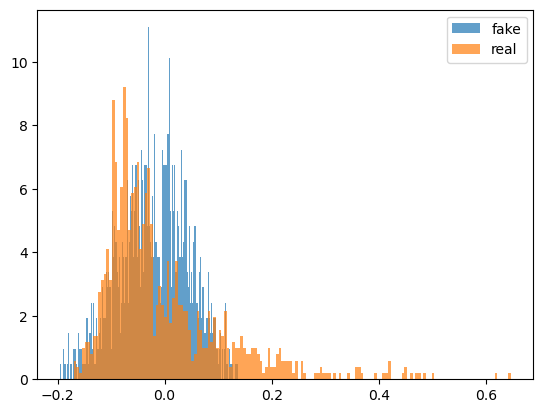

Epoch: 255 Loss D.: -0.030583245679736137 Loss G.: 0.0022785577457398176 KL Divergence.: 1.0014494913524628
Epoch: 256 Loss D.: -0.024440618231892586 Loss G.: 0.0015135209541767836 KL Divergence.: 0.6046821632251188
Epoch 256


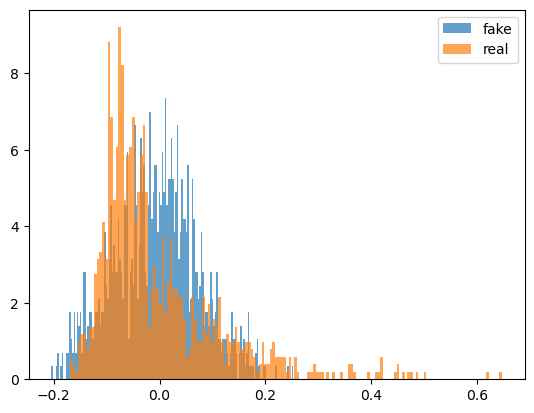

Epoch: 257 Loss D.: -0.03446551784873009 Loss G.: -0.002692174632102251 KL Divergence.: 2.7059860748779965
Epoch: 258 Loss D.: -0.03349741920828819 Loss G.: -0.0012417479883879423 KL Divergence.: 0.6237547281336706
Epoch 258


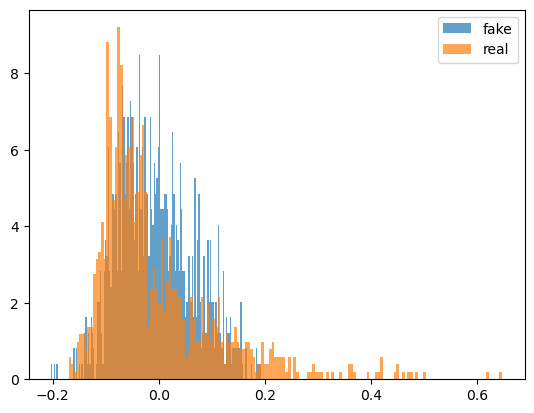

Epoch: 259 Loss D.: -0.030077246949076653 Loss G.: -0.0046210018917918205 KL Divergence.: 2.6177767098527074
Epoch: 260 Loss D.: -0.031017085537314415 Loss G.: -0.0010491664288565516 KL Divergence.: 1.899630308999121
Epoch: 261 Loss D.: -0.03303052857518196 Loss G.: 0.00039831153117120266 KL Divergence.: 5.619296566973883
Epoch: 262 Loss D.: -0.030845025554299355 Loss G.: -0.005667736753821373 KL Divergence.: 4.14513899271715
Epoch: 263 Loss D.: -0.027021639049053192 Loss G.: -0.0026788252871483564 KL Divergence.: 2.184568026276382
Epoch: 264 Loss D.: -0.03309600055217743 Loss G.: -0.004976699128746986 KL Divergence.: 5.340832897288459
Epoch: 265 Loss D.: -0.04512745141983032 Loss G.: -0.0008435434428974986 KL Divergence.: 0.5874870019542191
Epoch 265


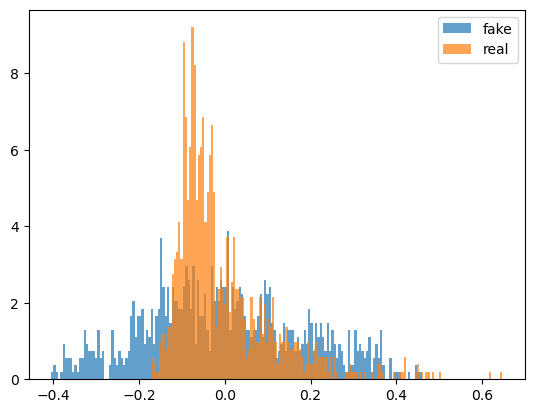

Epoch: 266 Loss D.: -0.03812607750296593 Loss G.: -0.0019357861019670963 KL Divergence.: 5.916675910149582
Epoch: 267 Loss D.: -0.02963440679013729 Loss G.: 0.0011835719924420118 KL Divergence.: 0.47196620718680304
Epoch 267


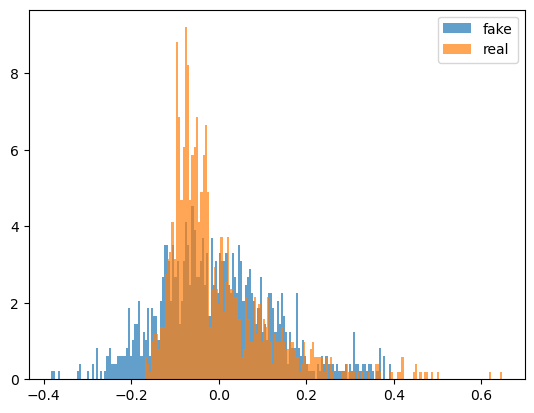

Epoch: 268 Loss D.: -0.030449561774730682 Loss G.: -0.0015384379075840116 KL Divergence.: 1.142667769745238
Epoch: 269 Loss D.: -0.03540788218379021 Loss G.: -0.0022899264004081488 KL Divergence.: 1.3274979970750138
Epoch: 270 Loss D.: -0.031222105026245117 Loss G.: 0.00016997678903862834 KL Divergence.: 0.47389076137256725
Epoch 270


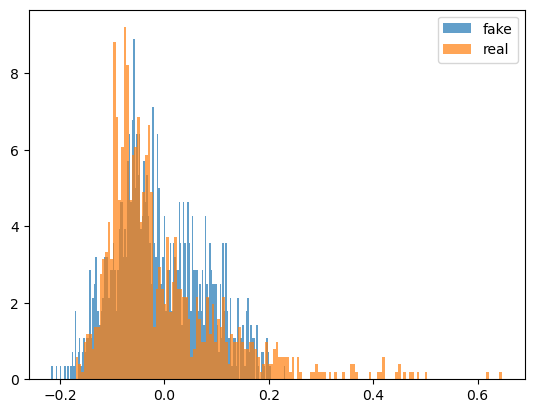

Epoch: 271 Loss D.: -0.03614170104265213 Loss G.: 0.0018979404121637344 KL Divergence.: 1.4410090302773337
Epoch: 272 Loss D.: -0.03159543126821518 Loss G.: 0.00228802184574306 KL Divergence.: 0.9475515345604776
Epoch 272


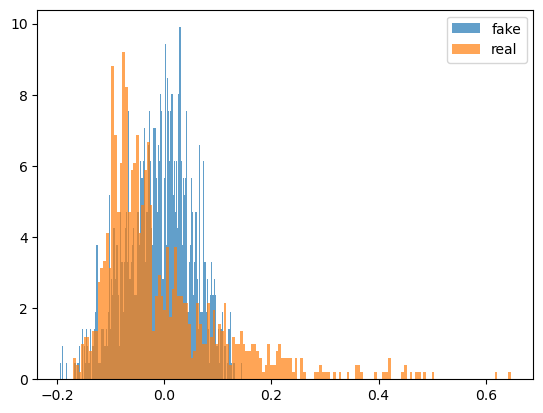

Epoch: 273 Loss D.: -0.029066039249300957 Loss G.: 0.00012884425814263523 KL Divergence.: 6.099466630035157
Epoch: 274 Loss D.: -0.030177617445588112 Loss G.: 0.0020146912429481745 KL Divergence.: 5.860504580567811
Epoch: 275 Loss D.: -0.02932734414935112 Loss G.: -0.002386208390817046 KL Divergence.: 4.464373994212594
Epoch: 276 Loss D.: -0.030026817694306374 Loss G.: -0.0002780894283205271 KL Divergence.: 0.6142576787067335
Epoch 276


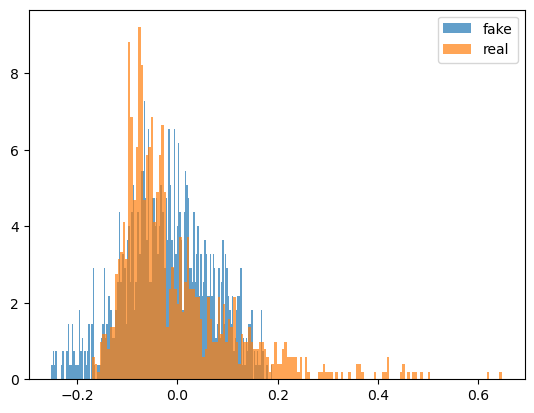

Epoch: 277 Loss D.: -0.035436563193798065 Loss G.: 0.0004925321554765105 KL Divergence.: 5.534054871341269
Epoch: 278 Loss D.: -0.036052919924259186 Loss G.: -0.004998736083507538 KL Divergence.: 6.1145455809266425
Epoch: 279 Loss D.: -0.028796032071113586 Loss G.: -0.00036774808540940285 KL Divergence.: 5.540072777627696
Epoch: 280 Loss D.: -0.035516880452632904 Loss G.: 0.0033928141929209232 KL Divergence.: 5.604668227415464
Epoch: 281 Loss D.: -0.02993006817996502 Loss G.: -0.0018828391330316663 KL Divergence.: 6.040393218214114
Epoch: 282 Loss D.: -0.03009401634335518 Loss G.: -0.0006484771147370338 KL Divergence.: 5.5493292761826964
Epoch: 283 Loss D.: -0.03414300084114075 Loss G.: -0.001858790754340589 KL Divergence.: 0.5537134900760715
Epoch 283


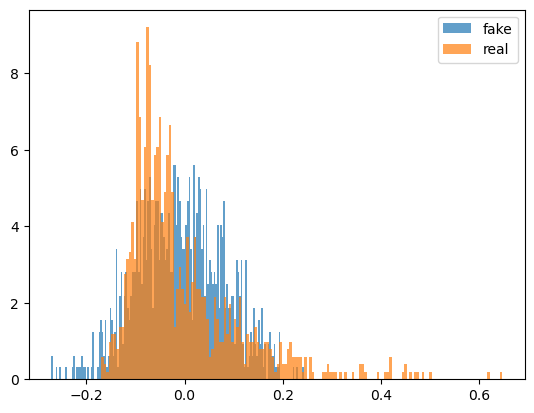

Epoch: 284 Loss D.: -0.03376440703868866 Loss G.: 0.0010554009350016713 KL Divergence.: 2.953037392850515
Epoch: 285 Loss D.: -0.03329622745513916 Loss G.: -0.00232453690841794 KL Divergence.: 5.3784243699524055
Epoch: 286 Loss D.: -0.0324145182967186 Loss G.: 0.00039717782055959105 KL Divergence.: 5.350787611978527
Epoch: 287 Loss D.: -0.03066563792526722 Loss G.: -0.00031269158353097737 KL Divergence.: 0.6673192392782388
Epoch 287


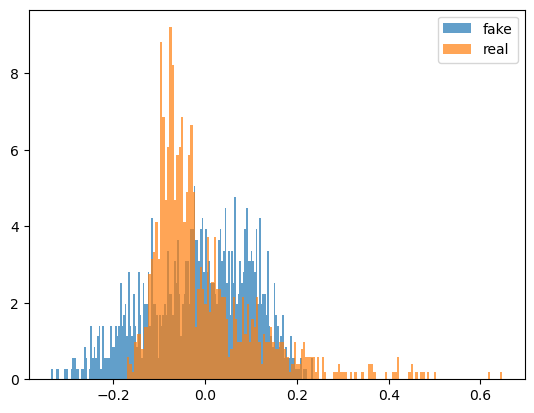

Epoch: 288 Loss D.: -0.02897019311785698 Loss G.: 0.0022168438881635666 KL Divergence.: 1.1896460667940667
Epoch: 289 Loss D.: -0.028390027582645416 Loss G.: -0.0029517586808651686 KL Divergence.: 0.6994388106591795
Epoch 289


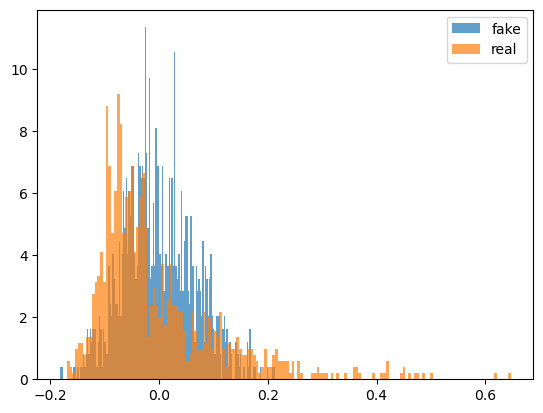

Epoch: 290 Loss D.: -0.02881847508251667 Loss G.: -0.0009322866098955274 KL Divergence.: 5.848729313275171
Epoch: 291 Loss D.: -0.03498629480600357 Loss G.: -0.0013134084874764085 KL Divergence.: 3.143639384556308
Epoch: 292 Loss D.: -0.032006509602069855 Loss G.: 0.0008108581532724202 KL Divergence.: 3.749907496295827
Epoch: 293 Loss D.: -0.03367297351360321 Loss G.: 0.0025309035554528236 KL Divergence.: 5.182279671373012
Epoch: 294 Loss D.: -0.03216557204723358 Loss G.: -0.002134565031155944 KL Divergence.: 1.054127171935598
Epoch: 295 Loss D.: -0.029435889795422554 Loss G.: -0.0014081625267863274 KL Divergence.: 5.668034900410141
Epoch: 296 Loss D.: -0.03036273643374443 Loss G.: -0.003479012520983815 KL Divergence.: 0.751568133561128
Epoch 296


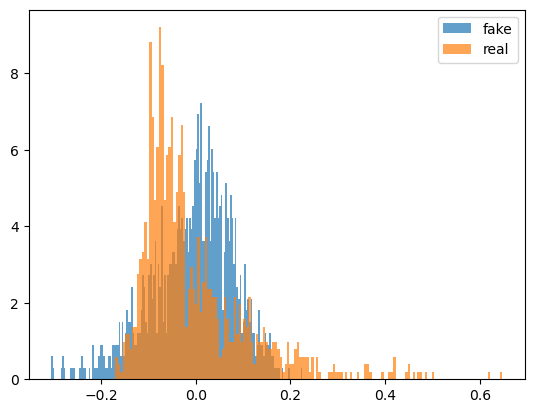

Epoch: 297 Loss D.: -0.02314765937626362 Loss G.: -0.0002644668857101351 KL Divergence.: 2.1354532544354763
Epoch: 298 Loss D.: -0.0348890982568264 Loss G.: -0.0029900334775447845 KL Divergence.: 1.0081935653031224
Epoch: 299 Loss D.: -0.027577508240938187 Loss G.: -0.00013911869609728456 KL Divergence.: 2.8502487553665867
Epoch: 300 Loss D.: -0.02922985330224037 Loss G.: 0.0007859076140448451 KL Divergence.: 5.785654715234944
Epoch: 301 Loss D.: -0.02856186404824257 Loss G.: -0.0004954581381753087 KL Divergence.: 2.5750965121990532
Epoch: 302 Loss D.: -0.03169766440987587 Loss G.: -0.00221812236122787 KL Divergence.: 5.8743955378917985
Epoch: 303 Loss D.: -0.03612254559993744 Loss G.: -0.002808698220178485 KL Divergence.: 5.839516614421214
Epoch: 304 Loss D.: -0.029218167066574097 Loss G.: -0.00717065529897809 KL Divergence.: 1.122563950588417
Epoch: 305 Loss D.: -0.03056296519935131 Loss G.: -0.001606977079063654 KL Divergence.: 3.4837143684706797
Epoch: 306 Loss D.: -0.0290360264480

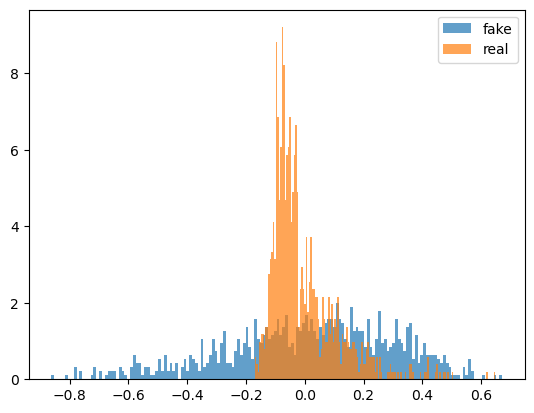

Epoch: 309 Loss D.: -0.03726101294159889 Loss G.: -0.0014029386220499873 KL Divergence.: 4.795003034071983
Epoch: 310 Loss D.: -0.03876369073987007 Loss G.: -0.0006160936900414526 KL Divergence.: 3.4222787692434644
Epoch: 311 Loss D.: -0.03275802358984947 Loss G.: 0.0012199199991300702 KL Divergence.: 2.0811207180185294
Epoch: 312 Loss D.: -0.04591312259435654 Loss G.: -0.007548226043581963 KL Divergence.: 0.4965233955379377
Epoch 312


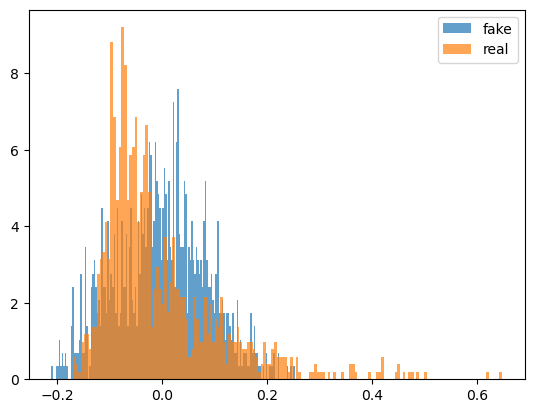

Epoch: 313 Loss D.: -0.028786931186914444 Loss G.: -0.00282078143209219 KL Divergence.: 4.41430494651086
Epoch: 314 Loss D.: -0.03178078308701515 Loss G.: 0.0031189159490168095 KL Divergence.: 5.889243426238344
Epoch: 315 Loss D.: -0.029893288388848305 Loss G.: 0.0022474080324172974 KL Divergence.: 0.5300548877597031
Epoch 315


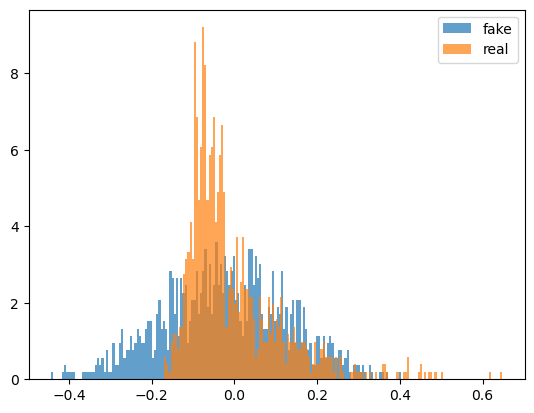

Epoch: 316 Loss D.: -0.0301167331635952 Loss G.: -0.006605022121220827 KL Divergence.: 4.663116915848526
Epoch: 317 Loss D.: -0.02490212954580784 Loss G.: 0.0007249398622661829 KL Divergence.: 4.952926240028843
Epoch: 318 Loss D.: -0.028851157054305077 Loss G.: -0.00270681525580585 KL Divergence.: 4.896481271104689
Epoch: 319 Loss D.: -0.031065648421645164 Loss G.: 0.0004881516215391457 KL Divergence.: 6.206321261667443
Epoch: 320 Loss D.: -0.04169279709458351 Loss G.: -0.0006953582633286715 KL Divergence.: 0.5138376423933753
Epoch 320


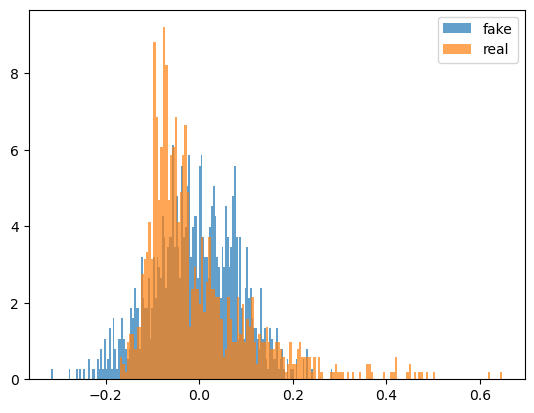

Epoch: 321 Loss D.: -0.030243847519159317 Loss G.: 0.002190234139561653 KL Divergence.: 0.7844276760410978
Epoch 321


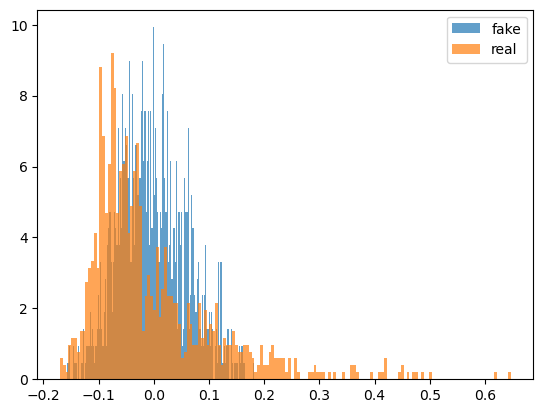

Epoch: 322 Loss D.: -0.026502391323447227 Loss G.: 0.0019896626472473145 KL Divergence.: 4.831218888562529
Epoch: 323 Loss D.: -0.027346810325980186 Loss G.: 0.003189983544871211 KL Divergence.: 6.066879637938828
Epoch: 324 Loss D.: -0.03496364876627922 Loss G.: -0.0010315249674022198 KL Divergence.: 4.614006717820469
Epoch: 325 Loss D.: -0.03266509249806404 Loss G.: 0.0008621305460110307 KL Divergence.: 0.6533617436334122
Epoch 325


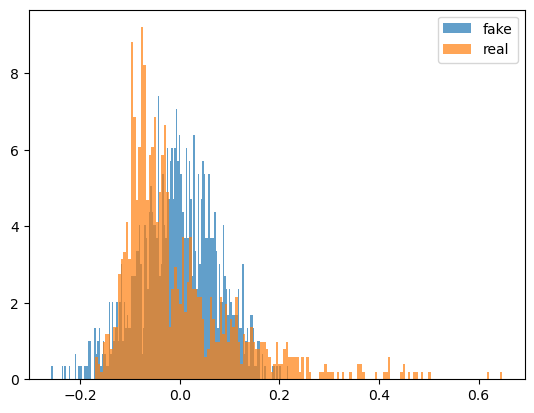

Epoch: 326 Loss D.: -0.026642806828022003 Loss G.: 0.003477591322734952 KL Divergence.: 5.845963552419346
Epoch: 327 Loss D.: -0.042855046689510345 Loss G.: -0.0007746953051537275 KL Divergence.: 5.880593196820106
Epoch: 328 Loss D.: -0.04766657575964928 Loss G.: -0.0040908679366111755 KL Divergence.: 0.7099226577034708
Epoch 328


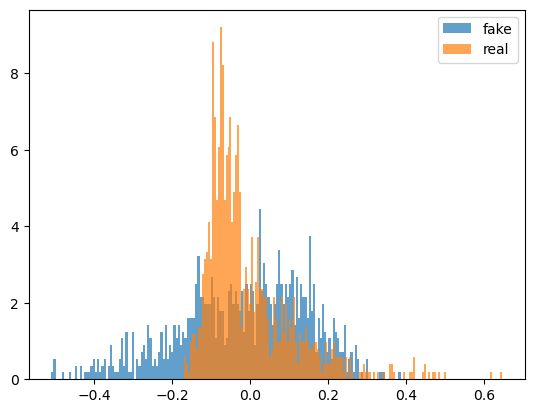

Epoch: 329 Loss D.: -0.03392891213297844 Loss G.: -9.750493336468935e-05 KL Divergence.: 5.32136039447891
Epoch: 330 Loss D.: -0.027235329151153564 Loss G.: 0.00033522513695061207 KL Divergence.: 1.8809311365004788
Epoch: 331 Loss D.: -0.028215184807777405 Loss G.: 0.0006303202244453132 KL Divergence.: 5.625047038553979
Epoch: 332 Loss D.: -0.031694937497377396 Loss G.: 0.0011909158201888204 KL Divergence.: 6.172426153486821
Epoch: 333 Loss D.: -0.04096054658293724 Loss G.: 0.0004131031164433807 KL Divergence.: 1.312582766840224
Epoch: 334 Loss D.: -0.032379526644945145 Loss G.: 0.002157747745513916 KL Divergence.: 2.51509235149605
Epoch: 335 Loss D.: -0.025875281542539597 Loss G.: -0.0006815015804022551 KL Divergence.: 0.32318848339028006
Epoch 335


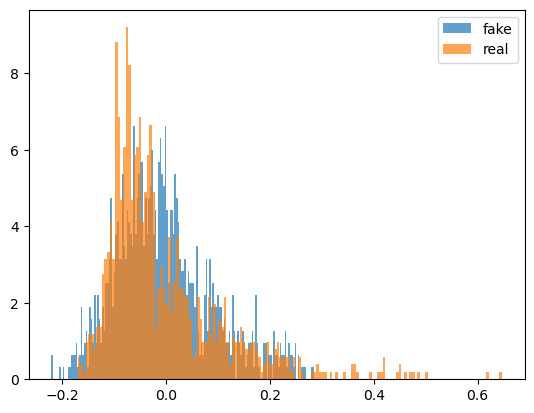

Epoch: 336 Loss D.: -0.033468931913375854 Loss G.: -0.0010062307119369507 KL Divergence.: 1.2169612440638713
Epoch: 337 Loss D.: -0.03167176991701126 Loss G.: -0.00042551473597995937 KL Divergence.: 5.930861033801686
Epoch: 338 Loss D.: -0.029501555487513542 Loss G.: 0.0012018700363114476 KL Divergence.: 1.2903199323511942
Epoch: 339 Loss D.: -0.030745215713977814 Loss G.: 0.00024288290296681225 KL Divergence.: 4.604966592478383
Epoch: 340 Loss D.: -0.039076004177331924 Loss G.: -0.0033072445075958967 KL Divergence.: 3.2355631265632647
Epoch: 341 Loss D.: -0.02973523736000061 Loss G.: -0.0009566691005602479 KL Divergence.: 1.2621175504987414
Epoch: 342 Loss D.: -0.033606842160224915 Loss G.: -0.002971682697534561 KL Divergence.: 4.7597479101328855
Epoch: 343 Loss D.: -0.030597243458032608 Loss G.: 0.0032071182504296303 KL Divergence.: 4.974591138622047
Epoch: 344 Loss D.: -0.030977768823504448 Loss G.: -0.0007176678045652807 KL Divergence.: 5.527263476893994
Epoch: 345 Loss D.: -0.0318

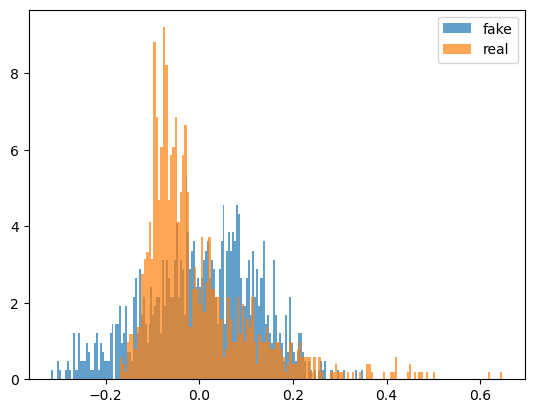

Epoch: 347 Loss D.: -0.033500466495752335 Loss G.: -0.0042771389707922935 KL Divergence.: 0.9013022571903907
Epoch 347


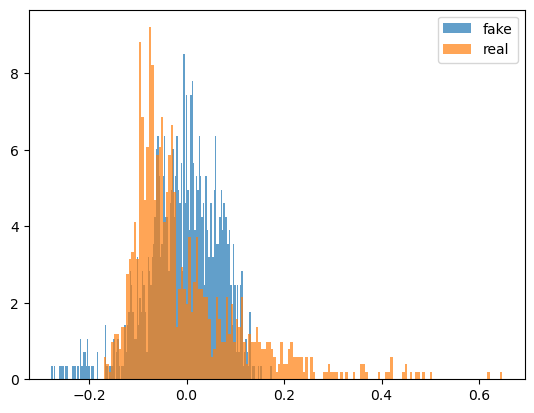

Epoch: 348 Loss D.: -0.029954321682453156 Loss G.: -0.0025752726942300797 KL Divergence.: 5.461806965986174
Epoch: 349 Loss D.: -0.03068271093070507 Loss G.: -0.0009691417217254639 KL Divergence.: 1.3047340386985717
Epoch: 350 Loss D.: -0.033719323575496674 Loss G.: 0.0007140801753848791 KL Divergence.: 1.7113826705400048
Epoch: 351 Loss D.: -0.025272326543927193 Loss G.: -0.0013003882486373186 KL Divergence.: 1.645367432032194
Epoch: 352 Loss D.: -0.03544287383556366 Loss G.: -0.0001235744566656649 KL Divergence.: 4.763191337460941
Epoch: 353 Loss D.: -0.03253835812211037 Loss G.: -0.0021816107910126448 KL Divergence.: 4.557039715641886
Epoch: 354 Loss D.: -0.031357523053884506 Loss G.: -0.003109268844127655 KL Divergence.: 5.259899572168354
Epoch: 355 Loss D.: -0.03416048362851143 Loss G.: -0.000130277534481138 KL Divergence.: 1.2888191364465185
Epoch: 356 Loss D.: -0.029863588511943817 Loss G.: -0.0013053666334599257 KL Divergence.: 5.710042840466879
Epoch: 357 Loss D.: -0.038221750

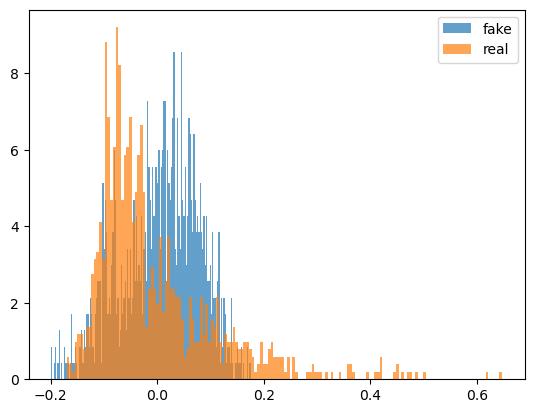

Epoch: 359 Loss D.: -0.028720082715153694 Loss G.: -0.0010713367955759168 KL Divergence.: 0.5510560999696112
Epoch 359


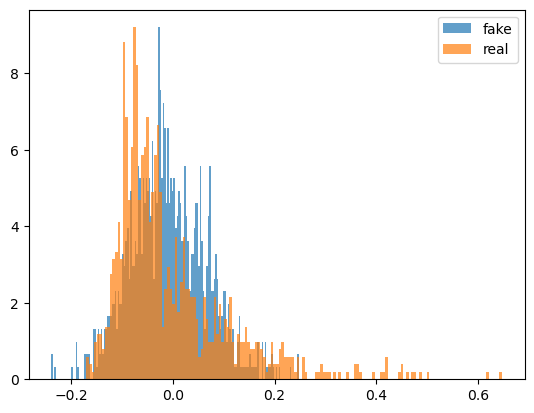

Epoch: 360 Loss D.: -0.032756976783275604 Loss G.: -0.002038277219980955 KL Divergence.: 3.020020924934302
Epoch: 361 Loss D.: -0.027645820751786232 Loss G.: -0.0004141785902902484 KL Divergence.: 4.489897156486823
Epoch: 362 Loss D.: -0.027632461860775948 Loss G.: 0.0028995720203965902 KL Divergence.: 0.748884269383618
Epoch 362


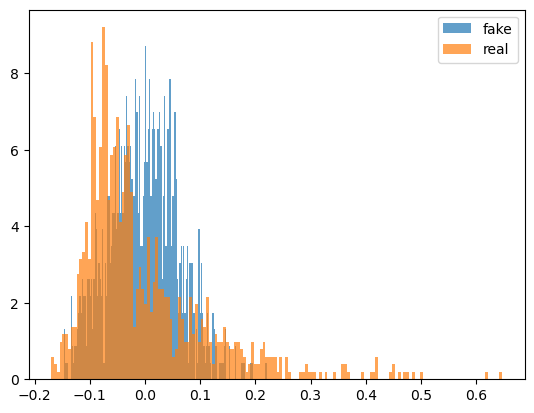

Epoch: 363 Loss D.: -0.033014051616191864 Loss G.: -0.0011563978623598814 KL Divergence.: 2.692375277896892
Epoch: 364 Loss D.: -0.02623375877737999 Loss G.: 0.0028761369176208973 KL Divergence.: 0.7387066813561429
Epoch 364


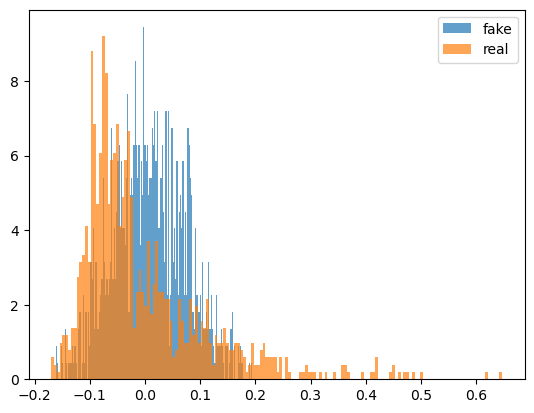

Epoch: 365 Loss D.: -0.033829234540462494 Loss G.: 0.002821427071467042 KL Divergence.: 4.246833536120535
Epoch: 366 Loss D.: -0.02395894192159176 Loss G.: -0.00200077798217535 KL Divergence.: 0.7605969542809543
Epoch 366


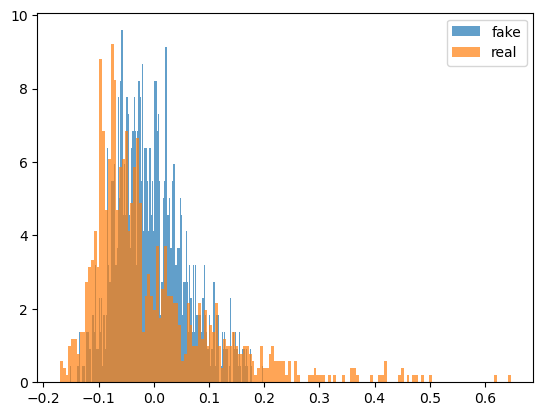

Epoch: 367 Loss D.: -0.027030853554606438 Loss G.: 0.0004886065144091845 KL Divergence.: 5.952967946787288
Epoch: 368 Loss D.: -0.027437204495072365 Loss G.: -0.0014550324995070696 KL Divergence.: 4.996761132643272
Epoch: 369 Loss D.: -0.02725214883685112 Loss G.: 0.00011717504821717739 KL Divergence.: 1.0944664285940195
Epoch: 370 Loss D.: -0.049266181886196136 Loss G.: -0.004332648124545813 KL Divergence.: 0.48336663986036005
Epoch 370


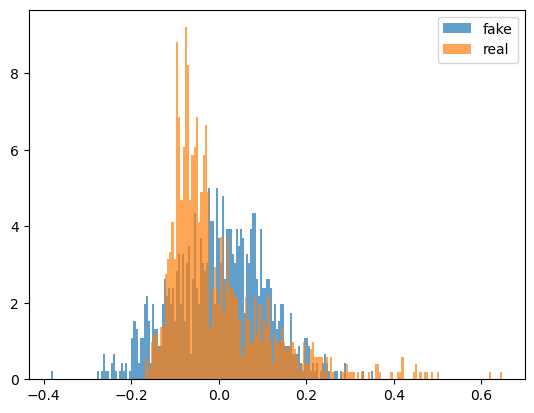

Epoch: 371 Loss D.: -0.030592180788517 Loss G.: -0.0022144566755741835 KL Divergence.: 5.358787215662257
Epoch: 372 Loss D.: -0.02991528995335102 Loss G.: 0.001863246550783515 KL Divergence.: 5.519192250073534
Epoch: 373 Loss D.: -0.03221140801906586 Loss G.: -0.0033123816829174757 KL Divergence.: 5.265505514433405
Epoch: 374 Loss D.: -0.02749049663543701 Loss G.: 0.0005790623836219311 KL Divergence.: 3.7253144973956154
Epoch: 375 Loss D.: -0.028389764949679375 Loss G.: 0.0002011174219660461 KL Divergence.: 0.647222153326174
Epoch 375


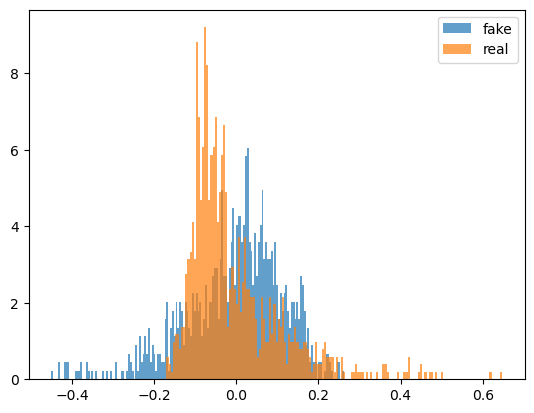

Epoch: 376 Loss D.: -0.027855118736624718 Loss G.: -0.000702735735103488 KL Divergence.: 1.2186434148992689
Epoch: 377 Loss D.: -0.033077992498874664 Loss G.: 0.0013414667919278145 KL Divergence.: 1.952098089995991
Epoch: 378 Loss D.: -0.02880239672958851 Loss G.: -0.0023073656484484673 KL Divergence.: 5.5936404350134055
Epoch: 379 Loss D.: -0.035113200545310974 Loss G.: -0.0009729625307954848 KL Divergence.: 5.733820220457823
Epoch: 380 Loss D.: -0.03422242030501366 Loss G.: -0.0022078375332057476 KL Divergence.: 5.8388410176765735
Epoch: 381 Loss D.: -0.029374098405241966 Loss G.: -0.002691078232601285 KL Divergence.: 3.367239262384264
Epoch: 382 Loss D.: -0.029954973608255386 Loss G.: -0.0021848941687494516 KL Divergence.: 5.6502771780925425
Epoch: 383 Loss D.: -0.03175339847803116 Loss G.: -0.00015162027557380497 KL Divergence.: 6.002733477359583
Epoch: 384 Loss D.: -0.05292023718357086 Loss G.: -0.0027729712892323732 KL Divergence.: 4.902774324436129
Epoch: 385 Loss D.: -0.0275104

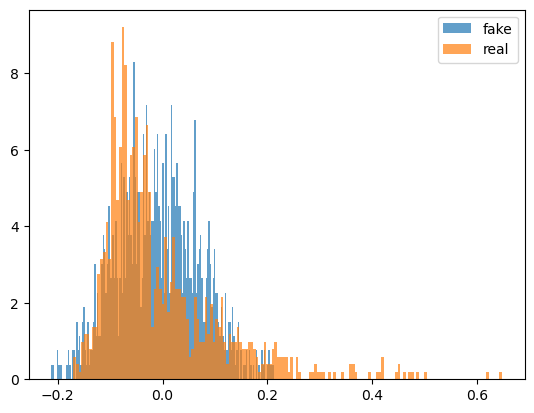

Epoch: 389 Loss D.: -0.03165605664253235 Loss G.: -0.00024003582075238228 KL Divergence.: 0.6940075363001829
Epoch 389


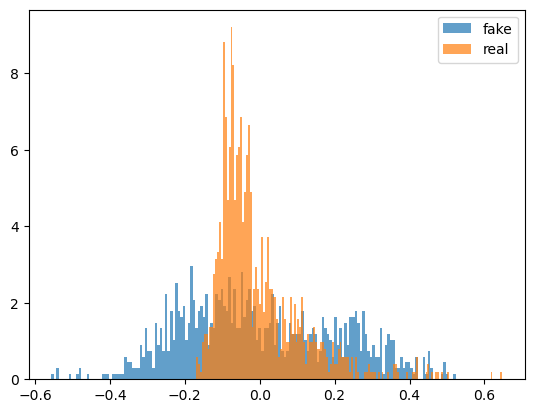

Epoch: 390 Loss D.: -0.030982211232185364 Loss G.: -0.0019262854475528002 KL Divergence.: 0.5172599267396231
Epoch 390


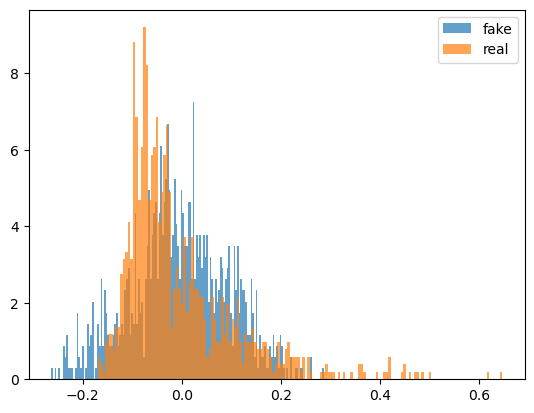

Epoch: 391 Loss D.: -0.030256150290369987 Loss G.: -0.0006145498482510448 KL Divergence.: 5.102455148643061
Epoch: 392 Loss D.: -0.02981993369758129 Loss G.: -5.0569273298606277e-05 KL Divergence.: 0.47730176983004
Epoch 392


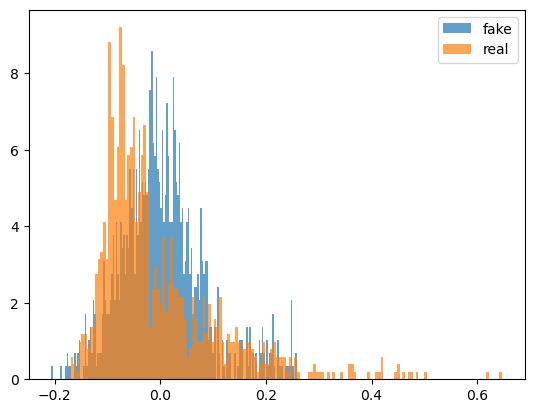

Epoch: 393 Loss D.: -0.029729872941970825 Loss G.: 0.0004561597597785294 KL Divergence.: 6.060573280640217
Epoch: 394 Loss D.: -0.03188105672597885 Loss G.: -0.0015560230240225792 KL Divergence.: 0.6766343883667844
Epoch 394


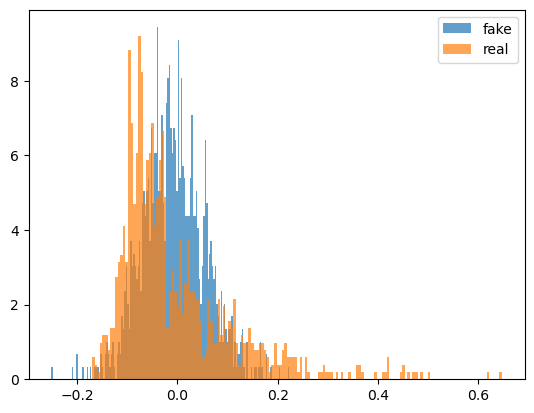

Epoch: 395 Loss D.: -0.02769496850669384 Loss G.: 0.00044708463246934116 KL Divergence.: 6.291708045688641
Epoch: 396 Loss D.: -0.03479157015681267 Loss G.: 0.003870890010148287 KL Divergence.: 5.449844903916997
Epoch: 397 Loss D.: -0.03230586647987366 Loss G.: 0.0001054735912475735 KL Divergence.: 0.5149444883016403
Epoch 397


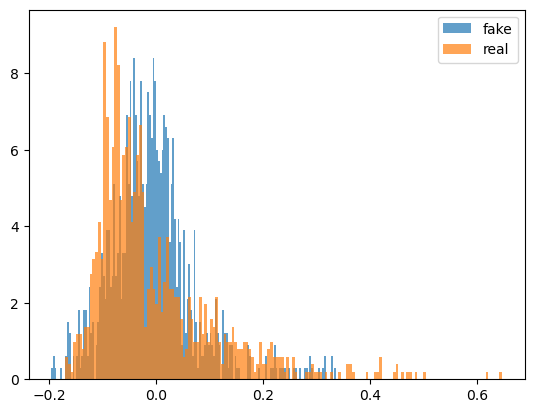

Epoch: 398 Loss D.: -0.030509136617183685 Loss G.: 0.0010154955089092255 KL Divergence.: 4.994544967923171
Epoch: 399 Loss D.: -0.030756857246160507 Loss G.: -0.00110330106690526 KL Divergence.: 5.84599585556474
Epoch: 400 Loss D.: -0.03372397646307945 Loss G.: 0.0013892077840864658 KL Divergence.: 4.759507762977329
Epoch: 401 Loss D.: -0.027581272646784782 Loss G.: -0.001841322286054492 KL Divergence.: 0.7330883040368368
Epoch 401


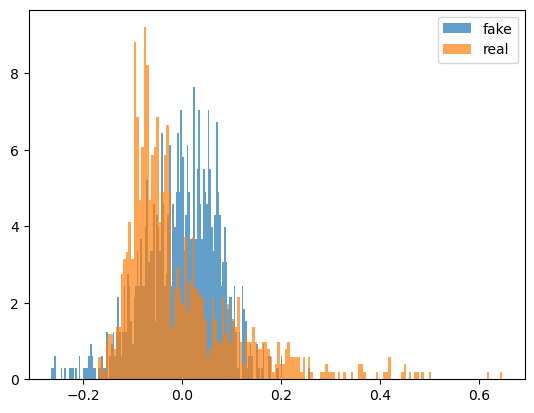

Epoch: 402 Loss D.: -0.028601132333278656 Loss G.: -0.0024411119520664215 KL Divergence.: 4.037818171514754
Epoch: 403 Loss D.: -0.034663714468479156 Loss G.: -0.004181999713182449 KL Divergence.: 5.532410309960365
Epoch: 404 Loss D.: -0.03356100618839264 Loss G.: 0.00049067527288571 KL Divergence.: 5.464919565405653
Epoch: 405 Loss D.: -0.03404783830046654 Loss G.: -0.0032156123779714108 KL Divergence.: 3.184396038987755
Epoch: 406 Loss D.: -0.028626836836338043 Loss G.: 0.0023337923921644688 KL Divergence.: 5.558070080168044
Epoch: 407 Loss D.: -0.026767563074827194 Loss G.: -0.0027761899400502443 KL Divergence.: 0.54052072552865
Epoch 407


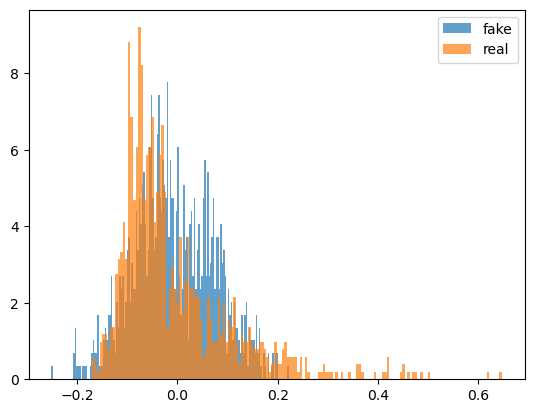

Epoch: 408 Loss D.: -0.03226092830300331 Loss G.: 0.00014838750939816236 KL Divergence.: 5.398650316130558
Epoch: 409 Loss D.: -0.046979550272226334 Loss G.: -0.0019106102408841252 KL Divergence.: 1.7467788136800495
Epoch: 410 Loss D.: -0.03124685399234295 Loss G.: 0.0019572856836020947 KL Divergence.: 0.7543591992002391
Epoch 410


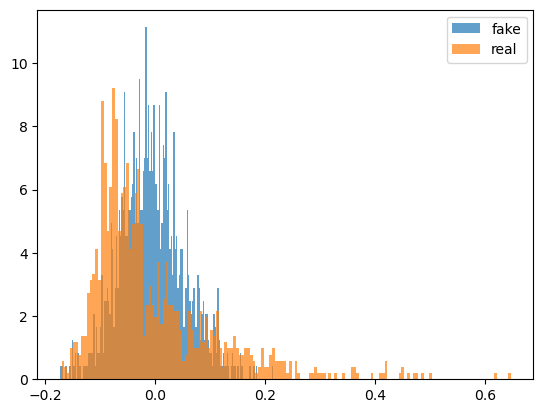

Epoch: 411 Loss D.: -0.028014523908495903 Loss G.: -0.0022795815020799637 KL Divergence.: 5.491610869839496
Epoch: 412 Loss D.: -0.032525546848773956 Loss G.: -0.002899231854826212 KL Divergence.: 0.881638603315925
Epoch 412


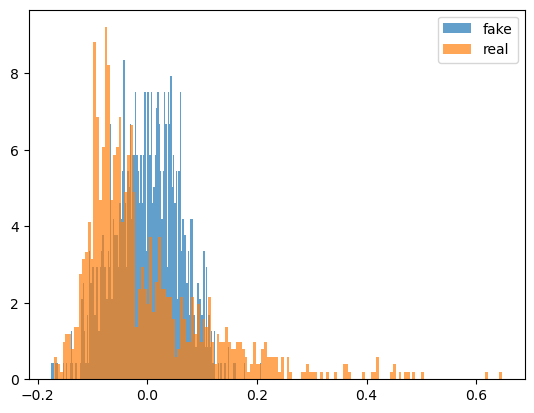

Epoch: 413 Loss D.: -0.033907901495695114 Loss G.: 8.410881855525076e-05 KL Divergence.: 4.6454617159104235
Epoch: 414 Loss D.: -0.03585544228553772 Loss G.: -0.005800250917673111 KL Divergence.: 5.203415616987668
Epoch: 415 Loss D.: -0.037590205669403076 Loss G.: -0.004672919400036335 KL Divergence.: 5.518838206838332
Epoch: 416 Loss D.: -0.03208286687731743 Loss G.: 0.0012528372462838888 KL Divergence.: 0.5657386011576622
Epoch 416


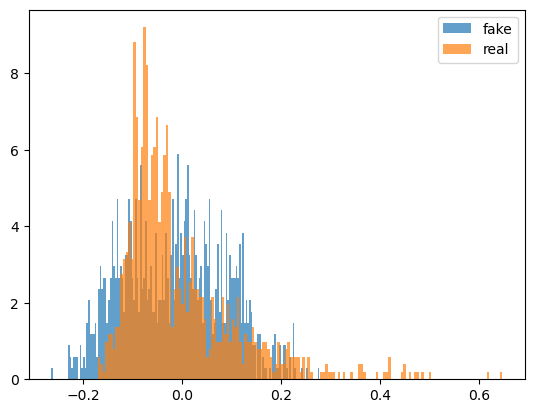

Epoch: 417 Loss D.: -0.038957320153713226 Loss G.: -0.005131620913743973 KL Divergence.: 0.4501724967907191
Epoch 417


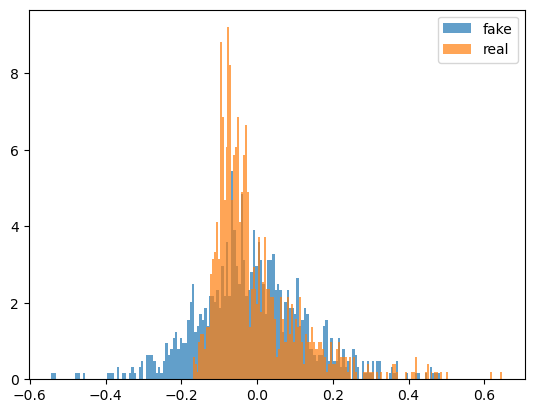

Epoch: 418 Loss D.: -0.02948201447725296 Loss G.: -0.00011490780161693692 KL Divergence.: 0.8454920119850484
Epoch 418


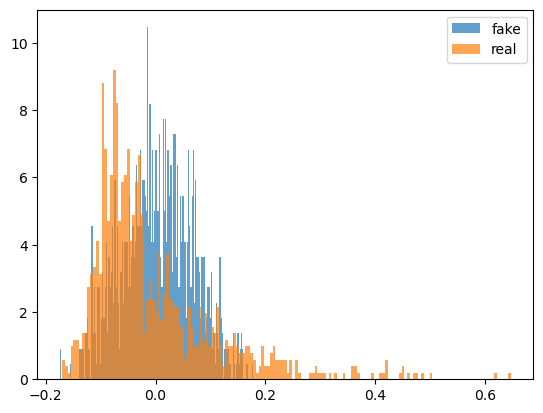

Epoch: 419 Loss D.: -0.03270484507083893 Loss G.: 0.0010806986829265952 KL Divergence.: 3.8081535148592414
Epoch: 420 Loss D.: -0.033904194831848145 Loss G.: -0.00037711436743848026 KL Divergence.: 5.411617128451112
Epoch: 421 Loss D.: -0.03423633798956871 Loss G.: -0.001684781163930893 KL Divergence.: 5.560444782451706
Epoch: 422 Loss D.: -0.02674945257604122 Loss G.: 0.0003570769331417978 KL Divergence.: 0.8098625515692617
Epoch 422


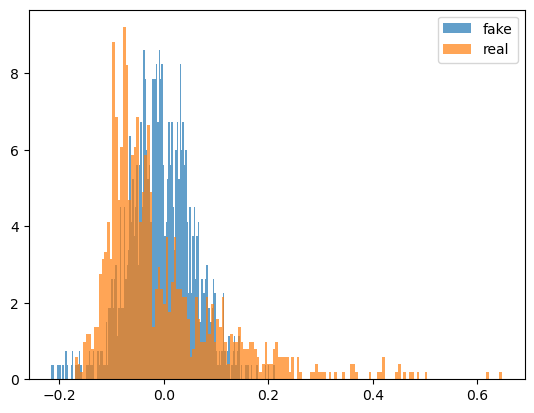

Epoch: 423 Loss D.: -0.032563481479883194 Loss G.: -0.0009575089788995683 KL Divergence.: 0.5928535918613766
Epoch 423


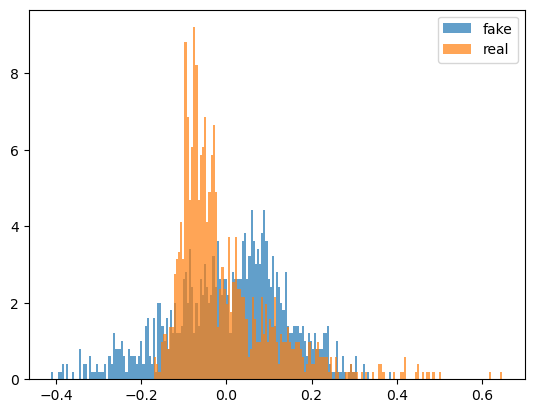

Epoch: 424 Loss D.: -0.0312117338180542 Loss G.: -0.0006696400814689696 KL Divergence.: 4.9141267232767145
Epoch: 425 Loss D.: -0.033184077590703964 Loss G.: 0.0014708987437188625 KL Divergence.: 5.874644390236809
Epoch: 426 Loss D.: -0.03588256612420082 Loss G.: 0.0005517584504559636 KL Divergence.: 2.1077932786278115
Epoch: 427 Loss D.: -0.03246635943651199 Loss G.: -0.004396962467581034 KL Divergence.: 0.9996939220665335
Epoch 427


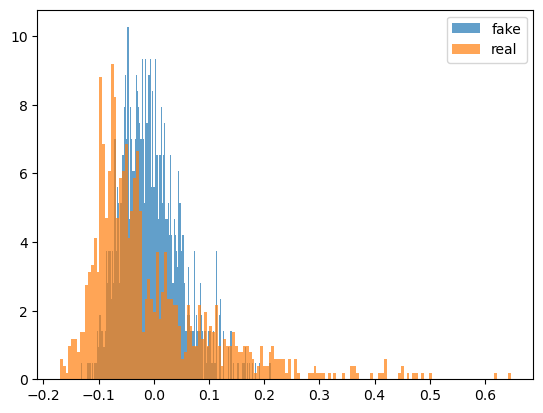

Epoch: 428 Loss D.: -0.026062000542879105 Loss G.: -0.00018862742581404746 KL Divergence.: 6.061228700578266
Epoch: 429 Loss D.: -0.02919694036245346 Loss G.: -0.000450238527264446 KL Divergence.: 5.27919018708282
Epoch: 430 Loss D.: -0.031259190291166306 Loss G.: -0.004670501220971346 KL Divergence.: 0.45765407808209013
Epoch 430


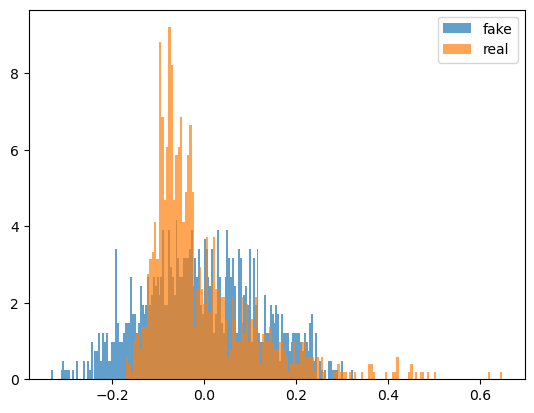

Epoch: 431 Loss D.: -0.03102370724081993 Loss G.: -5.6580291129648685e-05 KL Divergence.: 4.764339233709892
Epoch: 432 Loss D.: -0.04211263731122017 Loss G.: -0.0036052376963198185 KL Divergence.: 6.194568603164635
Epoch: 433 Loss D.: -0.030633794143795967 Loss G.: -0.002036110730841756 KL Divergence.: 0.6852227208842936
Epoch 433


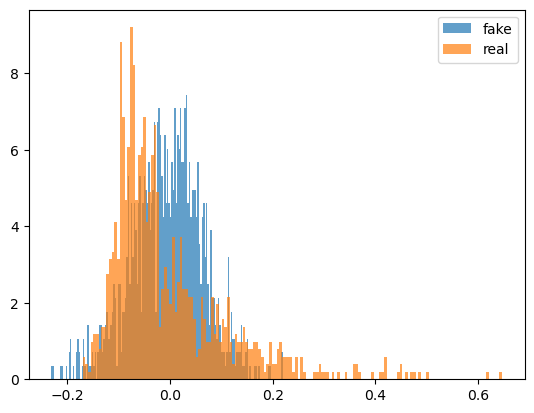

Epoch: 434 Loss D.: -0.027433879673480988 Loss G.: -0.0022316386457532644 KL Divergence.: 5.288730064596569
Epoch: 435 Loss D.: -0.03262624517083168 Loss G.: -0.004728042986243963 KL Divergence.: 0.50153753931378
Epoch 435


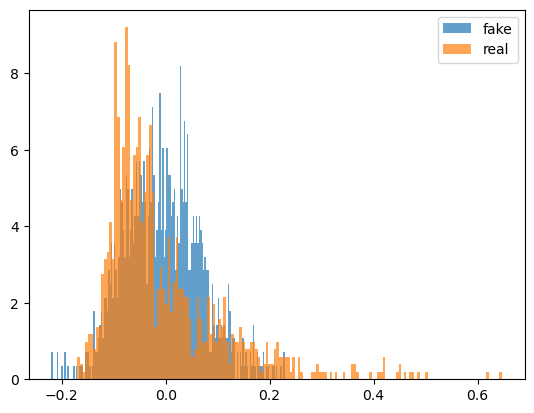

Epoch: 436 Loss D.: -0.02805500105023384 Loss G.: -0.004149740096181631 KL Divergence.: 5.45400240902125
Epoch: 437 Loss D.: -0.037355296313762665 Loss G.: 0.002347414381802082 KL Divergence.: 0.8003989356457712
Epoch 437


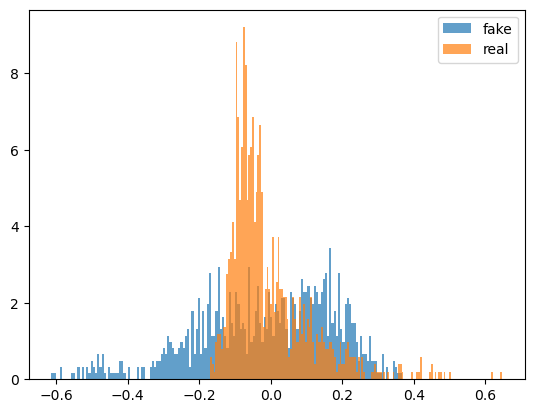

Epoch: 438 Loss D.: -0.029326774179935455 Loss G.: -0.0017941046971827745 KL Divergence.: 5.494342947812205
Epoch: 439 Loss D.: -0.030528606846928596 Loss G.: -0.0037840157747268677 KL Divergence.: 4.6585047308900585
Epoch: 440 Loss D.: -0.03142313286662102 Loss G.: -0.0031026587821543217 KL Divergence.: 5.565598795517846
Epoch: 441 Loss D.: -0.030683211982250214 Loss G.: 0.00018491742957849056 KL Divergence.: 5.217425725857984
Epoch: 442 Loss D.: -0.03160443156957626 Loss G.: 0.0012239026837050915 KL Divergence.: 5.354230169437752
Epoch: 443 Loss D.: -0.03734249621629715 Loss G.: -0.0004552080645225942 KL Divergence.: 2.4495913379413112
Epoch: 444 Loss D.: -0.0366680845618248 Loss G.: -0.0017727488884702325 KL Divergence.: 5.917914630500661
Epoch: 445 Loss D.: -0.0328504703938961 Loss G.: -0.00433348398655653 KL Divergence.: 1.3189292345476593
Epoch: 446 Loss D.: -0.03214435279369354 Loss G.: 0.0027473808731883764 KL Divergence.: 0.4632042034803262
Epoch 446


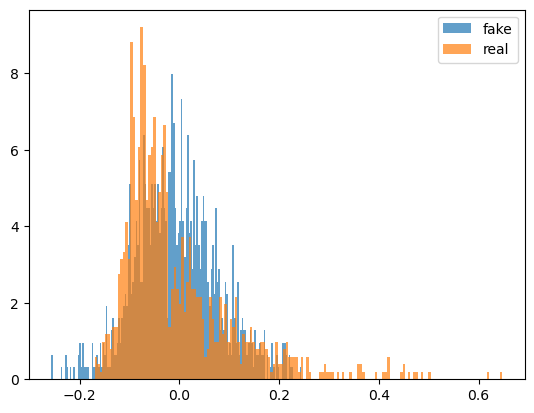

Epoch: 447 Loss D.: -0.03143562003970146 Loss G.: -0.002335750265046954 KL Divergence.: 5.37952038974122
Epoch: 448 Loss D.: -0.028514593839645386 Loss G.: -0.000897702295333147 KL Divergence.: 4.926126146149178
Epoch: 449 Loss D.: -0.027594193816184998 Loss G.: 0.0015986349899321795 KL Divergence.: 0.6666561491383481
Epoch 449


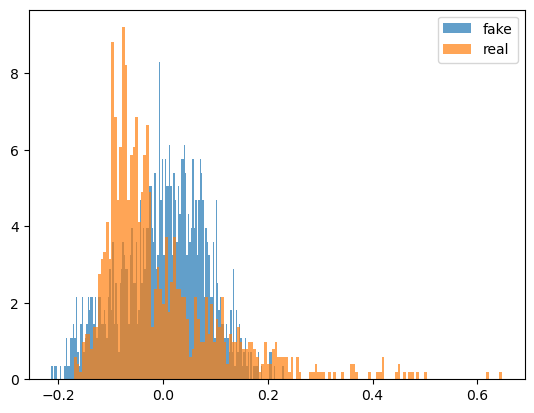

Epoch: 450 Loss D.: -0.03316274285316467 Loss G.: -0.0010108762653544545 KL Divergence.: 0.23096457654114683
Epoch 450


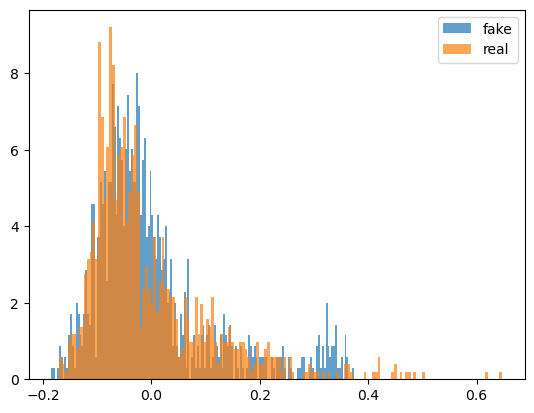

Epoch: 451 Loss D.: -0.030808666720986366 Loss G.: -0.0019172655884176493 KL Divergence.: 5.538421630736261
Epoch: 452 Loss D.: -0.02821272611618042 Loss G.: 0.0016532980371266603 KL Divergence.: 3.555662231974993
Epoch: 453 Loss D.: -0.026539815589785576 Loss G.: -0.00027071216027252376 KL Divergence.: 1.8087066681360235
Epoch: 454 Loss D.: -0.02242852747440338 Loss G.: -0.0021916329860687256 KL Divergence.: 5.493123538264394
Epoch: 455 Loss D.: -0.030334869399666786 Loss G.: 0.0006768643506802619 KL Divergence.: 0.5329937448802373
Epoch 455


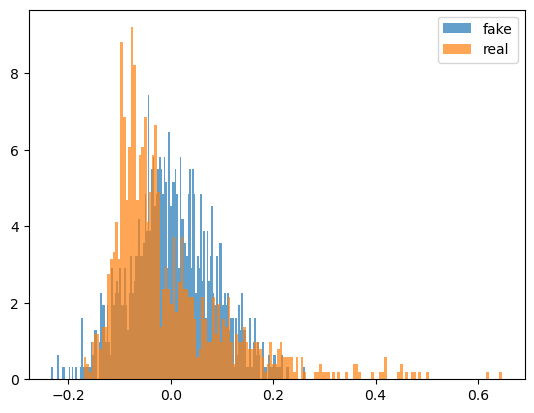

Epoch: 456 Loss D.: -0.05067915469408035 Loss G.: -3.652251325547695e-05 KL Divergence.: 5.414099204543945
Epoch: 457 Loss D.: -0.041813358664512634 Loss G.: -0.004106589127331972 KL Divergence.: 6.1789375014026815
Epoch: 458 Loss D.: -0.03463837131857872 Loss G.: -0.004786505363881588 KL Divergence.: 1.1142634825428552
Epoch: 459 Loss D.: -0.0256800539791584 Loss G.: -0.001227663946337998 KL Divergence.: 0.5244886524832237
Epoch 459


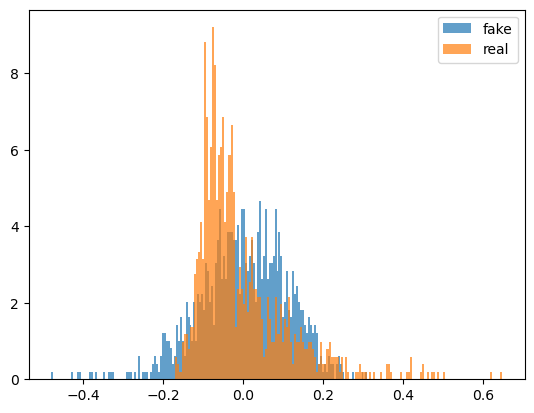

Epoch: 460 Loss D.: -0.031140223145484924 Loss G.: -0.0011612517992034554 KL Divergence.: 5.513088013750071
Epoch: 461 Loss D.: -0.03294358775019646 Loss G.: -2.708469401113689e-05 KL Divergence.: 5.118426888316495
Epoch: 462 Loss D.: -0.030496980994939804 Loss G.: -0.0026899240911006927 KL Divergence.: 0.8496753750320147
Epoch 462


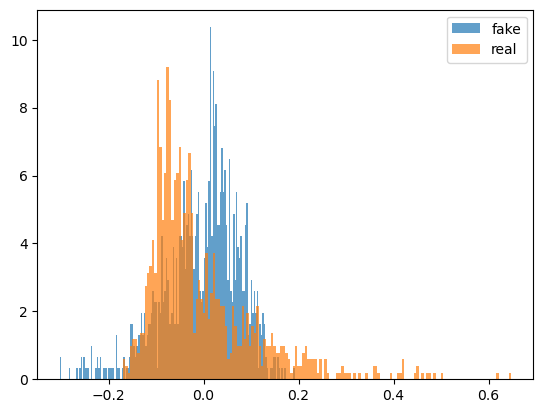

Epoch: 463 Loss D.: -0.032376281917095184 Loss G.: -0.0008040810935199261 KL Divergence.: 0.8202859070829897
Epoch 463


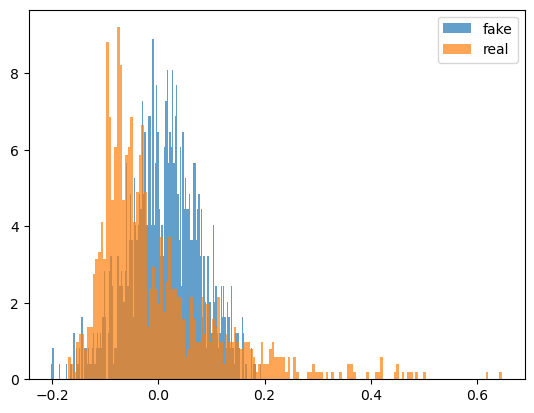

Epoch: 464 Loss D.: -0.03669966757297516 Loss G.: 0.0030120834708213806 KL Divergence.: 0.39355112608407944
Epoch 464


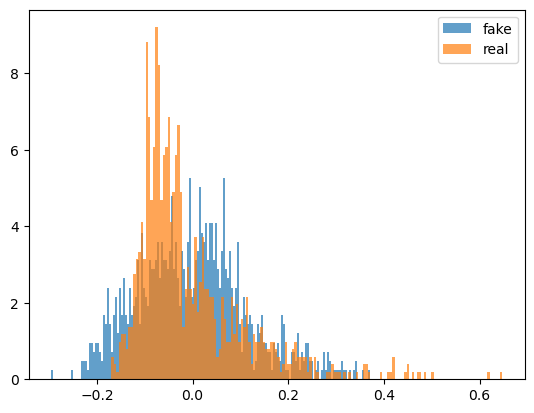

Epoch: 465 Loss D.: -0.03467445820569992 Loss G.: -0.0008156306575983763 KL Divergence.: 1.5229386234744855
Epoch: 466 Loss D.: -0.02724761888384819 Loss G.: -0.0021095569245517254 KL Divergence.: 3.3745451183657798
Epoch: 467 Loss D.: -0.0326918363571167 Loss G.: -0.0036042353603988886 KL Divergence.: 5.7242133520756955
Epoch: 468 Loss D.: -0.032509125769138336 Loss G.: -0.0010310935322195292 KL Divergence.: 0.35114344982863854
Epoch 468


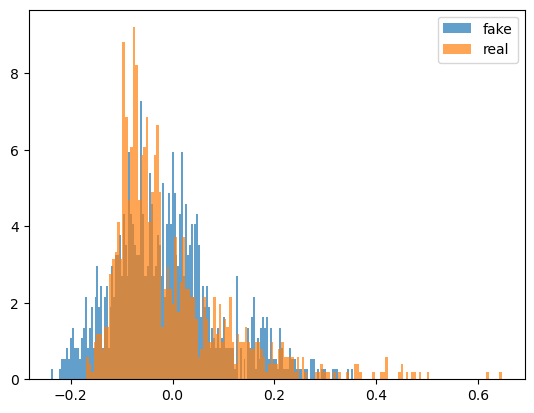

Epoch: 469 Loss D.: -0.028402011841535568 Loss G.: -0.0021505672484636307 KL Divergence.: 2.69399234083122
Epoch: 470 Loss D.: -0.03525298461318016 Loss G.: -0.0009573589195497334 KL Divergence.: 1.9110678450025793
Epoch: 471 Loss D.: -0.029368873685598373 Loss G.: -0.0013312341179698706 KL Divergence.: 5.378955747581887
Epoch: 472 Loss D.: -0.026634113863110542 Loss G.: -0.0003455430269241333 KL Divergence.: 6.229196102860055
Epoch: 473 Loss D.: -0.030841311439871788 Loss G.: 0.0020692762918770313 KL Divergence.: 5.949014353516404
Epoch: 474 Loss D.: -0.0327632874250412 Loss G.: 0.001989931333810091 KL Divergence.: 0.9126534146371741
Epoch 474


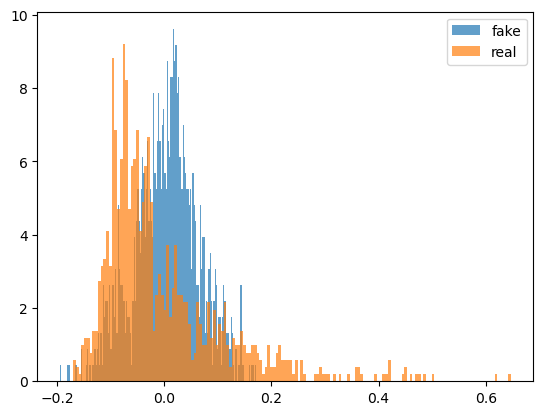

Epoch: 475 Loss D.: -0.03751051425933838 Loss G.: -0.003017835319042206 KL Divergence.: 1.1421062187385314
Epoch: 476 Loss D.: -0.03224775195121765 Loss G.: -0.0006728207226842642 KL Divergence.: 0.7648782540375361
Epoch 476


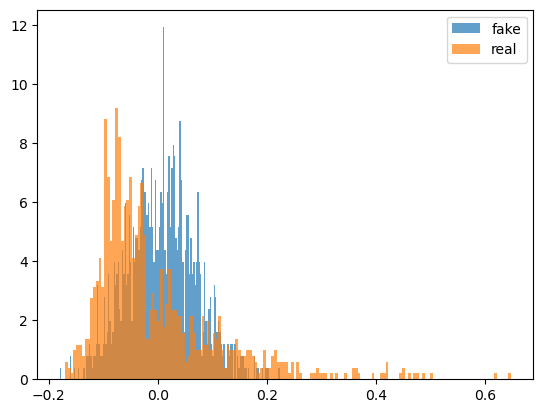

Epoch: 477 Loss D.: -0.03592466190457344 Loss G.: 0.0019834351260215044 KL Divergence.: 6.2401995976134685
Epoch: 478 Loss D.: -0.02856316789984703 Loss G.: -0.0014865160919725895 KL Divergence.: 5.508812936377358
Epoch: 479 Loss D.: -0.03172880783677101 Loss G.: -0.0010624154238030314 KL Divergence.: 2.7382653152427734
Epoch: 480 Loss D.: -0.03113233670592308 Loss G.: 0.004121748730540276 KL Divergence.: 0.8320503696696622
Epoch 480


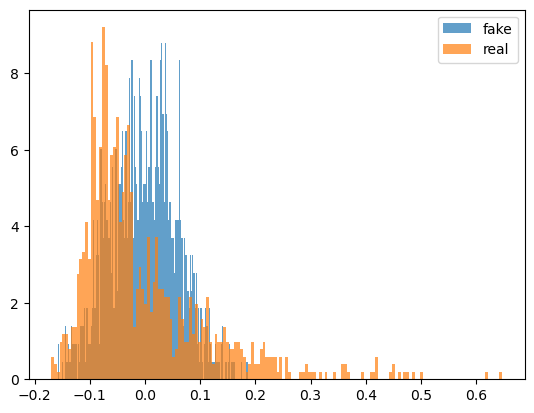

Epoch: 481 Loss D.: -0.02815585769712925 Loss G.: -0.004769191611558199 KL Divergence.: 6.214469891416157
Epoch: 482 Loss D.: -0.03372012823820114 Loss G.: 0.002431195229291916 KL Divergence.: 5.012465198135971
Epoch: 483 Loss D.: -0.026178358122706413 Loss G.: -0.001179916667751968 KL Divergence.: 1.5527568135697543
Epoch: 484 Loss D.: -0.03142695128917694 Loss G.: 0.0029161847196519375 KL Divergence.: 0.4144652390326559
Epoch 484


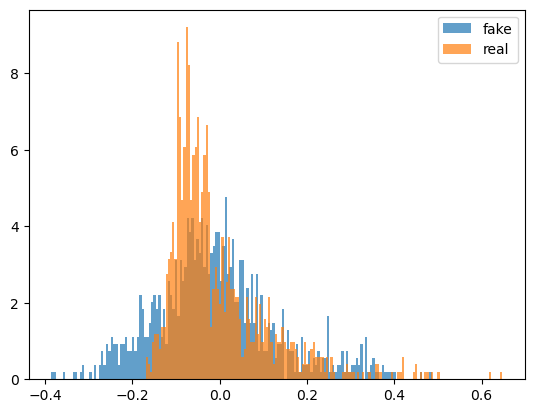

Epoch: 485 Loss D.: -0.02777271345257759 Loss G.: -0.003874124027788639 KL Divergence.: 0.7807501969889312
Epoch 485


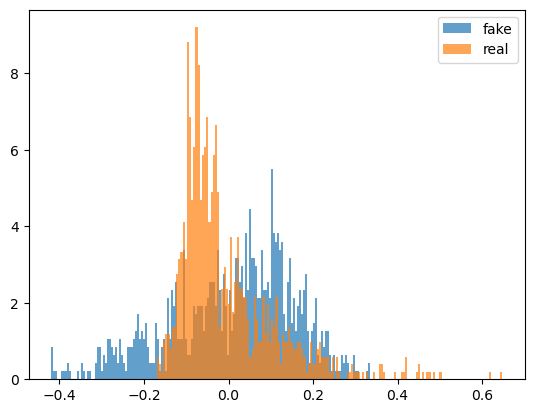

Epoch: 486 Loss D.: -0.02539040707051754 Loss G.: 0.0001881033240351826 KL Divergence.: 5.884908901007655
Epoch: 487 Loss D.: -0.030028942972421646 Loss G.: -0.0006406607571989298 KL Divergence.: 0.3945154717194203
Epoch 487


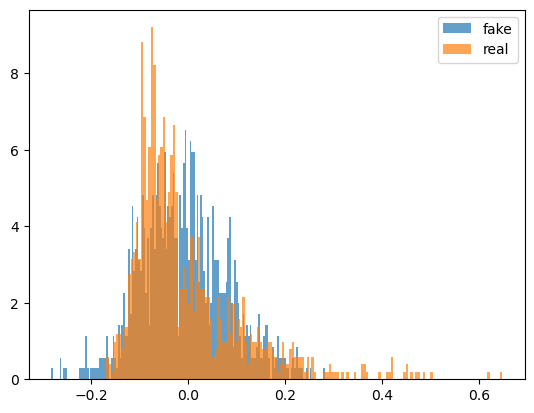

Epoch: 488 Loss D.: -0.027493895962834358 Loss G.: 0.00030220524058677256 KL Divergence.: 5.667169788789252
Epoch: 489 Loss D.: -0.028674982488155365 Loss G.: -0.0026850823778659105 KL Divergence.: 0.550355557895237
Epoch 489


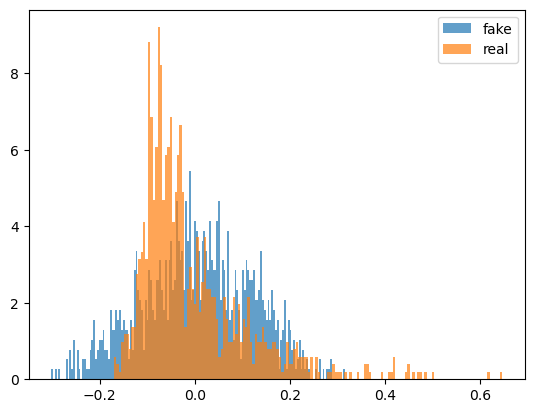

Epoch: 490 Loss D.: -0.0266597680747509 Loss G.: -0.0010892339050769806 KL Divergence.: 5.9858150295567105
Epoch: 491 Loss D.: -0.030245879665017128 Loss G.: -0.00014452903997153044 KL Divergence.: 1.055211593584228
Epoch: 492 Loss D.: -0.027565889060497284 Loss G.: 0.0014809740241616964 KL Divergence.: 2.8302666340273817
Epoch: 493 Loss D.: -0.02584386244416237 Loss G.: -0.0018067797645926476 KL Divergence.: 6.07113540467942
Epoch: 494 Loss D.: -0.030080677941441536 Loss G.: 0.0031969095580279827 KL Divergence.: 2.751153920553433
Epoch: 495 Loss D.: -0.027153870090842247 Loss G.: 0.00197050953283906 KL Divergence.: 0.6056322493081827
Epoch 495


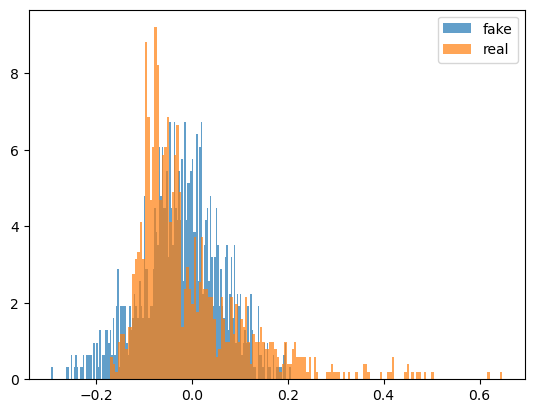

Epoch: 496 Loss D.: -0.02874237298965454 Loss G.: 0.0026990026235580444 KL Divergence.: 3.1181996737236934
Epoch: 497 Loss D.: -0.026988768950104713 Loss G.: -0.0008577120606787503 KL Divergence.: 0.2680569000421249
Epoch 497


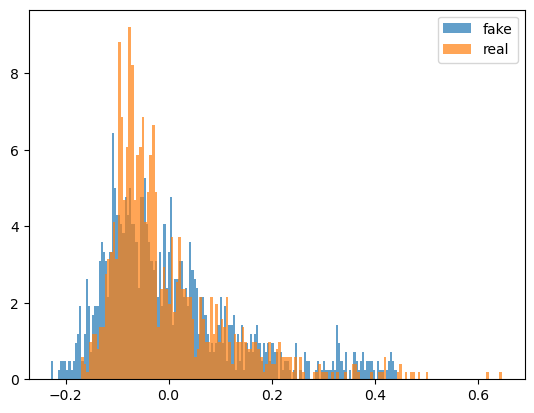

Epoch: 498 Loss D.: -0.029973363503813744 Loss G.: -0.0016825937200337648 KL Divergence.: 0.6433213545899964
Epoch 498


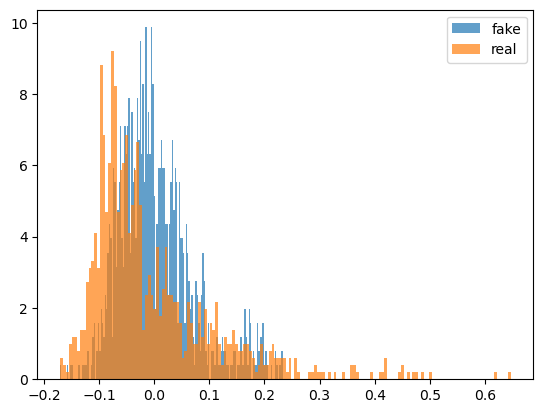

Epoch: 499 Loss D.: -0.03439873084425926 Loss G.: -0.0008370135328732431 KL Divergence.: 0.7061294946830248
Epoch 499


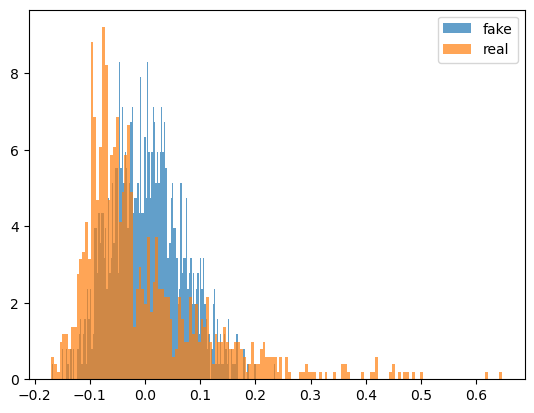

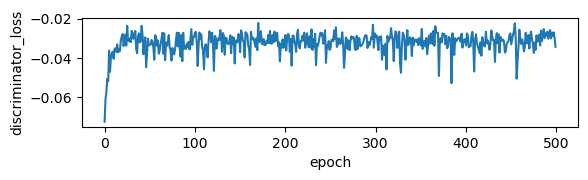

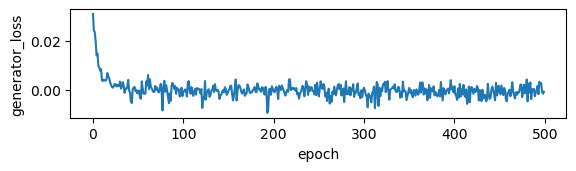

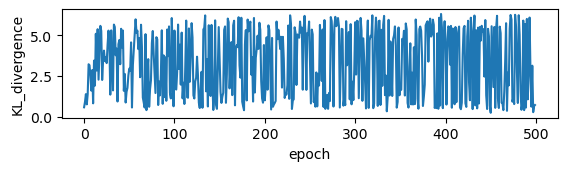

In [50]:
loss_disc = []
loss_gen = []
epochs= []
negkld = 0
kl_div_metric= []
for epoch in range(num_epochs):
    running_loss_disc = 0.0
    running_loss_gen = 0.0
    for n, (real_samples, _) in enumerate(train_loader):
        
        for _ in range(5):
        # Sample data
            real_samples_labels = torch.ones((batch_size, 1))
            latent_space_samples = torch.randn((batch_size, 1000))
            generated_samples = generator(latent_space_samples)   
            generated_samples_labels = torch.zeros((batch_size, 1))
            all_samples = torch.cat((real_samples, generated_samples))
            all_samples_labels = torch.cat(
                (real_samples_labels, generated_samples_labels)
            )

            # Dicriminator forward-loss-backward-update
            D_real = discriminator(real_samples.float())
            D_fake = discriminator(generated_samples)

            D_loss = -(torch.mean(D_real) - torch.mean(D_fake))

            D_loss.backward()
            optimizer_discriminator.step()

            # Weight clipping
            for p in discriminator.parameters():
                p.data.clamp_(-0.01, 0.01)

            # Housekeeping - reset gradient
            reset_grad()
            
        # Generator forward-loss-backward-update
        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 1000))
        generated_samples = generator(latent_space_samples)
        D_fake = discriminator(generated_samples)

        G_loss = -torch.mean(D_fake)

        G_loss.backward()
        optimizer_generator.step()

        # Housekeeping - reset gradient
        reset_grad()
        
        #print(epoch,n)
        if n == batch_size - 1:
            if epoch == 1:
            # Generating output arrays (Initial cycle)
                latent_space_samples = torch.randn(1, 1000)
                generated_samples = generator(latent_space_samples)
                print('Epoch 1')
                plt.figure()
                plt.hist(generated_samples[0].detach().numpy(), bins=160, density=True, alpha=0.7, label='fake')
                plt.hist(train_data[0], bins=160, density=True, alpha=0.7, label='real')
                plt.legend()
                plt.title('First Epoch')
                plt.show()
            
            epochs.append(epoch)
            running_loss_disc += D_loss.item() 
            #epoch_loss_disc = running_loss_disc / len(train_loader)
            epoch_loss_disc = running_loss_disc
            loss_disc.append(epoch_loss_disc)
            
            running_loss_gen += G_loss.item() 
            #epoch_loss_gen = running_loss_gen / len(train_loader)
            epoch_loss_gen = running_loss_gen
            loss_gen.append(epoch_loss_gen)
            
        # Print and plot every now and then
        if n == batch_size - 1:
            latent_space_samples = torch.randn(1, 1000)
            generated_samples = generator(latent_space_samples)
            smt_pgen = prob_generated(generated_samples)
            kldiv = kl_divergence_calc(smooth_preal, smt_pgen)
            kl_div_metric.append(kldiv)
            #if(kldiv < 0):
                #negkld = negkld+1
                
            print(f"Epoch: {epoch} Loss D.: {D_loss.data.numpy()} Loss G.: {G_loss.data.numpy()} KL Divergence.: {kldiv}")
            #print(f"Epoch: {epoch} Loss G.: {loss_generator}")
            if (kldiv > 0 and kldiv < 1):
                print('Epoch', epoch)
                plt.figure()
                plt.hist(generated_samples[0].detach().numpy(), bins=160, density=True, alpha=0.7, label='fake')
                plt.hist(train_data[0], bins=160, density=True, alpha=0.7, label='real')
                plt.legend()
                plt.show()

plt.subplot(3, 1, 1)
#plot the discriminator loss
plt.plot(epochs,loss_disc)
plt.xlabel('epoch')
plt.ylabel('discriminator_loss')
plt.show()
#plot the generator loss
plt.subplot(3, 1, 2)
plt.plot(epochs,loss_gen)
plt.xlabel('epoch')
plt.ylabel('generator_loss')
plt.show()
#plot the KL-divergence 
plt.subplot(3, 1, 3)
plt.plot(epochs,kl_div_metric)
plt.xlabel('epoch')
plt.ylabel('KL_divergence')
plt.show()  

In [51]:
pd.set_option('display.max_rows', None, 'display.max_columns', None)
#pd.reset_option("display.max_rows")
pd.options.display.max_rows = 10000
torch.set_printoptions(threshold=1500)
torch.set_printoptions(edgeitems=500)

In [52]:
#generate_data()
#generated_samples = generated_samples.detach()
#plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")

#pd.DataFrame(generated_samples[0]).plot()
#print(generated_samples)

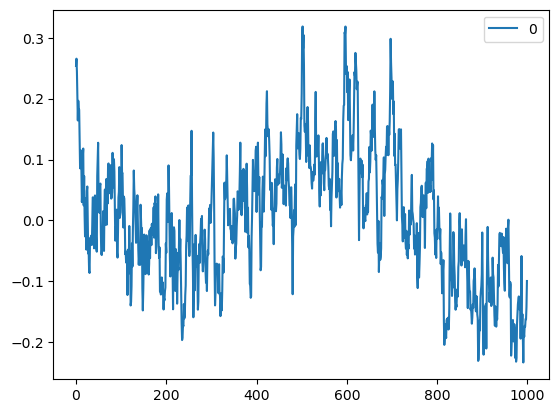

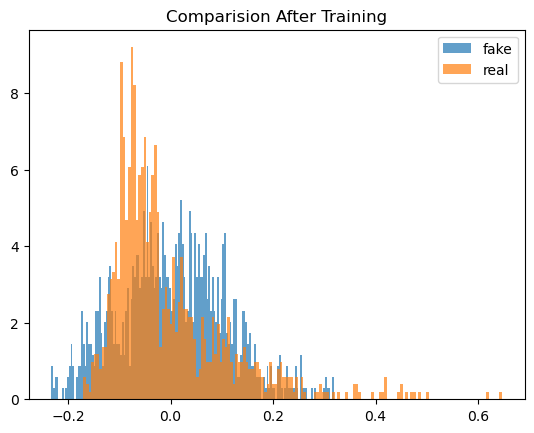

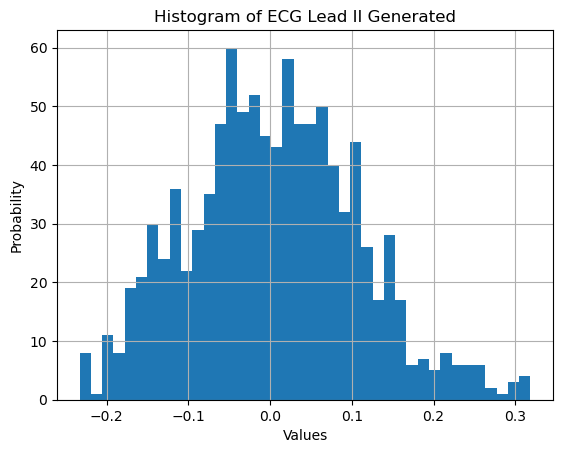

[[<AxesSubplot:title={'center':'Histogram of ECG Lead II Generated'}, xlabel='Values', ylabel='Probability'>]]
[<AxesSubplot:title={'center':'Histogram of ECG Lead II Generated'}, xlabel='Values', ylabel='Probability'>]


In [53]:
#print(generated_samples)

#max_gen_value = torch.max(generated_samples[0])
#min_gen_value = torch.min(generated_samples[0])
##print(min_gen_value,max_gen_value)
 

# the histogram of the data
#m, binss, patchess = plt.hist(generated_samples[0], 20)
latent_space_samples = torch.randn(1, 1000)
generated_samples = generator(latent_space_samples)
generated_samples = generated_samples.detach()
pd.DataFrame(generated_samples[0]).plot()

plt.figure()
plt.hist(generated_samples[0].detach().numpy(), bins=160, density=True, alpha=0.7, label='fake')
plt.hist(train_data[0], bins=160, density=True, alpha=0.7, label='real')
plt.legend()
plt.title('Comparision After Training')
plt.show()

#n, bins, patches = plt.hist(train_data[0], 20)
ax  = pd.DataFrame(generated_samples[0].detach().numpy()).hist(bins=40)

#print(m)
plt.xlabel('Values')
plt.ylabel('Probability')
plt.title('Histogram of ECG Lead II Generated')
plt.grid(True)
plt.show()


#ax = ax[0]
print(ax)
for x in ax: 
    print(x)
#prob_gen = m/1000
#prob_gen

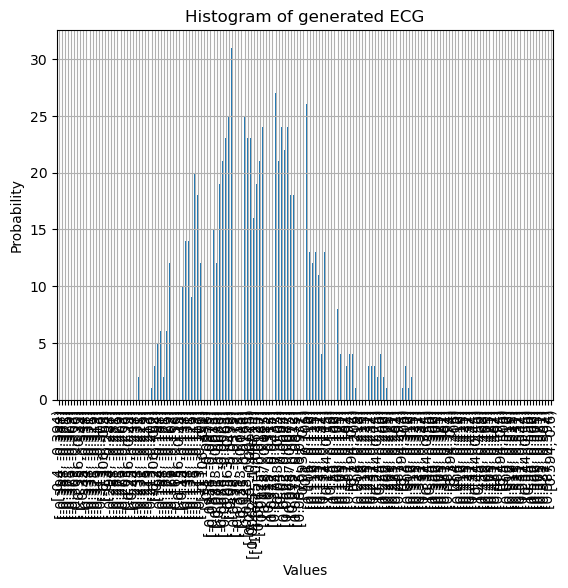

In [54]:
step = 0.00625
bin_range = np.arange(-0.4, 0.6+step, step)


outg, bins  = pd.cut(generated_samples[0].detach(), bins=bin_range, include_lowest=True, right=False, retbins=True)
outg.value_counts().plot.bar()
plt.xlabel('Values')
plt.ylabel('Probability')
plt.title('Histogram of generated ECG')
plt.grid(True)
plt.show()
df = outg.value_counts().rename_axis('values').reset_index(name='counts')
#print(df)
gen = df.counts.values
pgen = gen/1000
nonzero_pgen = np.count_nonzero(pgen)
#print(nonzero_pgen)
pgen_eps = eps/nonzero_pgen
#print(pgen_eps)
smooth_pgen = np.where(pgen != 0, pgen - pgen_eps, pgen_eps)
#print(smooth_pgen)
#print(pgen)
#print(gen)

In [55]:
kl_div_rg =kl_divergence_calc(smooth_preal, smooth_pgen)
kl_div_gr =kl_divergence_calc(smooth_pgen,smooth_preal)
print("KL divergence between real and generated ",kl_div_rg)
print("KL divergence between generated and real ",kl_div_gr)

KL divergence between real and generated  0.4922464662315793
KL divergence between generated and real  0.5509430869338189


In [69]:
latent_space_samples = torch.randn(1024, 1000)
generated_samples = generator(latent_space_samples)
generated_samples = generated_samples.detach()
generated_samples = generated_samples.numpy()
generated_samples.shape

(1024, 1000)

[ 0.00342927  0.00223192 -0.00730192 ... -0.00093805 -0.00590643
 -0.0140916 ]


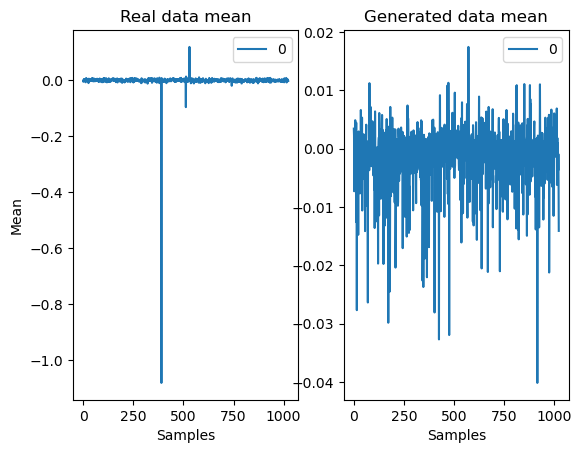

In [74]:
#define subplot layout
fig, axes = plt.subplots(nrows=1, ncols=2)

#Plot for real sample mean
real_data_mean = np.mean(train_data,axis=1)
#print(train_data_mean)
ax1 = pd.DataFrame(real_data_mean).plot(ax=axes[0], title='Real data mean')

#Plot for generated data mean
gen_data_mean = np.mean(generated_samples,axis=1)
print(gen_data_mean)
ax2 = pd.DataFrame(gen_data_mean).plot(ax=axes[1], title='Generated data mean')

ax1.set_xlabel("Samples")
ax2.set_xlabel("Samples")
ax1.set_ylabel("Mean")
plt.savefig('means_r_g.png')
plt.show()

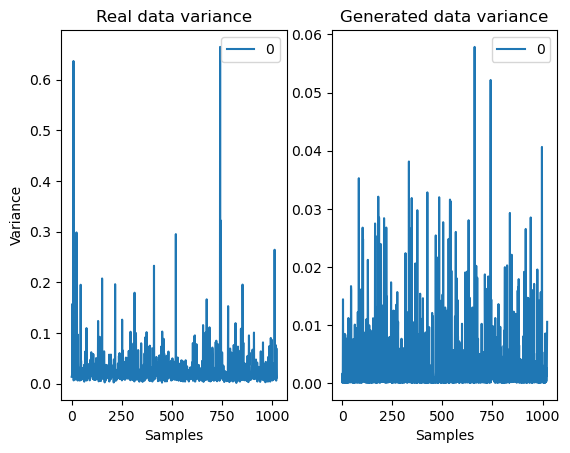

In [73]:
#define subplot layout
fig, axes = plt.subplots(nrows=1, ncols=2)
#Plot for training sample variance
real_data_var = np.var(train_data,axis=1)
#print(train_data_var)
ax3 = pd.DataFrame(real_data_var).plot(ax=axes[0], title='Real data variance')

#Plot for generated data variance
gen_data_var = np.var(generated_samples,axis=1)
#print(gen_data_var)
ax4 = pd.DataFrame(gen_data_var).plot(ax=axes[1], title='Generated data variance')

ax3.set_xlabel("Samples")
ax4.set_xlabel("Samples")
ax3.set_ylabel("Variance")
plt.savefig('var_r_g.png')
plt.show()

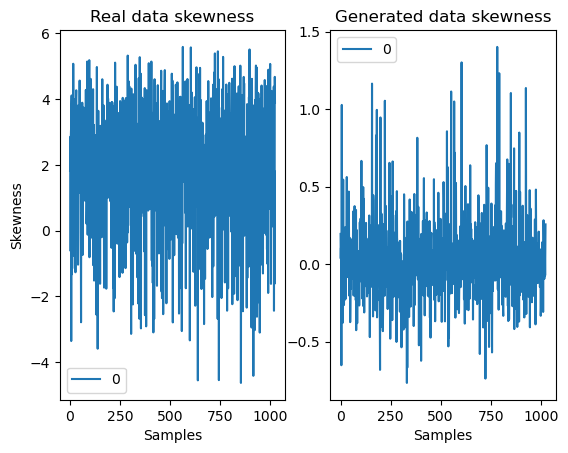

In [71]:
#define subplot layout
fig, axes = plt.subplots(nrows=1, ncols=2)
#Plot for training sample skewness
real_data_skew = skew(train_data,axis=1)
#print(train_data_skew)
ax5 = pd.DataFrame(real_data_skew).plot(ax=axes[0], title='Real data skewness')

#Plot for generated data skewness
gen_data_skew = skew(generated_samples,axis=1)
#print(gen_data_skew)
ax6 = pd.DataFrame(gen_data_skew).plot(ax=axes[1], title='Generated data skewness')

ax5.set_xlabel("Samples")
ax6.set_xlabel("Samples")
ax5.set_ylabel("Skewness")
plt.savefig('skew_r_g.png')
plt.show()

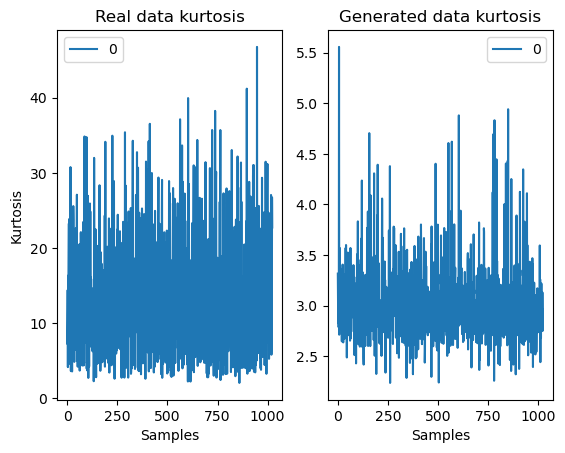

In [72]:
#define subplot layout
fig, axes = plt.subplots(nrows=1, ncols=2)
#Plot for training sample Kurtosis
real_data_kurtosis = kurtosis(train_data, fisher=False, axis=1)
#print(train_data_kurtosis)
ax7 = pd.DataFrame(real_data_kurtosis).plot(ax=axes[0], title='Real data kurtosis')

#Plot for generated data Kurtosis
gen_data_kurtosis = kurtosis(generated_samples, fisher=False, axis=1)
#print(gen_data_kurtosis)
ax8 = pd.DataFrame(gen_data_kurtosis).plot(ax=axes[1], title='Generated data kurtosis')

ax7.set_xlabel("Samples")
ax8.set_xlabel("Samples")
ax7.set_ylabel("Kurtosis")
plt.savefig('kurt_r_g.png')
plt.show()